<div class="alert alert-block alert-success"><font color="black"><h1><left>EDA of MIMIC ICU Data for Intestinal Conditions</left></h1></font></div>


In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
# File definitions
path = 'E:\Education\DataScience\CCSU-Data-Science\Data-Mining-And-Predictive-Analytics\Data-531\Data\\'
file1 = path + 'part-00000-diagnosis-code.snappy.parquet'
file2 = path + 'part-00000-admission-diags.snappy.parquet'
file3 = path + 'part-00000-admissions.snappy.parquet'
file4 = path + 'part-00000-note-events.snappy.parquet'
file6 = path + 'ICD10_Formatted.csv'

<div class="alert alert-block alert-success"><font color="black"><h1><left>Notebook Global Variables</left></h1>
</font></div>

In [4]:
# This variable is used to selected the max size of notes selected for analysis
note_length = 2000
# This dictionary is used to select icd10 codes used for the comparison charts
icd_codes_t = {  'A41.9':'Sepsis Unspecified Organism', 
                 'E11.9':'Diabetes Mellitu', 
                 'E78.4':'Unspecified Hyperlipidemia', 
                 'E78.0':'Pure Hypercholesterolemia', 
                 'I25.10':'Coronary Artherosclerosis',
                 'I21.9':'Unspecified Acute Myocardial Infarction',
                 'I21.4':'Subendocardial infarction, initial episode of care',
                 'I35.2':'Nonrheumatic Aortic (Valve) Stenosis with Insufficiency',
                 'I48.91':'Afib', 
                 'I50.9':'Unspecified Congestive Heart Failure', 
                 'J96.00':'Acute Respiratory Failure', 
                 'K25.0':'Acute Gastric Ulcer','K25.4':'Unspecified Chronic Gastric Ulcer',
                 'K29.90':'Gastroduodenitis','K29.91':'Unspecified Gastritis',
                 'K51.00':'Universal or Chronic Ulcerative Colitis','K51.90':'Unspecified Ulcerative Colitis',
                 'K56.60':'Unspecified Intestinal Obstruction', 'K56.69':'Other Specified Intestinal Obstruction', 
                 'K57.30':'Colon-1', 'K57.31':'Colon-2', 'K57.32':'Colon-3', 
                 'K21.9':'Reflux', 'I27.89':'Heart-1',
                 'K52.9':'Unspecified Gastroenteritis','K58.9':'Iterable Bowel Syndrome', 
                 'I27.89':'Other Specified Pulmonary Heart Diseases: ', 
                 'N17.9':'Acute Kidney Failure, Unspecified', 'N39.0':'Urinary Tract Infection'}

# This dictionary is used to select icd categories 'E78.4':'Unspecified Hyperlipidemia',  for the comparison charts
icd_codes2 = {'Ulcer':'darkred','Heart':'yellow', 'Gastritis':'green','Reflux':'plum', 'Blood':'blue','IBS':'brown',
              'Lungs':'teal','Kidney':'pink', 'Pancreas':'dark green', }


      

<div class="alert alert-block alert-success"><font color="black"><h1><left>Generate Core Dataframes</left></h1></font></div>


In [5]:
# diag codes dataframe contains codes and their descriptions
diag_codes = pd.read_parquet(file1,engine='auto',use_nullable_dtypes=True)
# admsn diag codes dataframe contains admission and assigned codes
admsn_diags = pd.read_parquet(file2,engine='auto',use_nullable_dtypes=True)
# admsn dataframe contains high level data about admission
admissions = pd.read_parquet(file3,engine='auto',use_nullable_dtypes=True)
#             [['hadm_id','subject_id','admittime', 'dischtime','diagnosis']]

C:\Users\rolan\AppData\Local\Temp\ipykernel_34680\3995562640.py:2: FutureWarning: The argument 'use_nullable_dtypes' is deprecated and will be removed in a future version.Use dtype_backend='numpy_nullable' instead of use_nullable_dtype=True.
  diag_codes = pd.read_parquet(file1,engine='auto',use_nullable_dtypes=True)
C:\Users\rolan\AppData\Local\Temp\ipykernel_34680\3995562640.py:4: FutureWarning: The argument 'use_nullable_dtypes' is deprecated and will be removed in a future version.Use dtype_backend='numpy_nullable' instead of use_nullable_dtype=True.
  admsn_diags = pd.read_parquet(file2,engine='auto',use_nullable_dtypes=True)
C:\Users\rolan\AppData\Local\Temp\ipykernel_34680\3995562640.py:6: FutureWarning: The argument 'use_nullable_dtypes' is deprecated and will be removed in a future version.Use dtype_backend='numpy_nullable' instead of use_nullable_dtype=True.
  admissions = pd.read_parquet(file3,engine='auto',use_nullable_dtypes=True)


In [6]:
admissions.columns

Index(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data'],
      dtype='object')

In [7]:
# Join the diag_codes descriptions witht he diagnosis code for the primary diagnosis for an admission
# find the top ten highest occurring diqgonsis codes not including newborn related

#diag_codes.columns
dlist = ["41011","41041","5789","430","431"]
good_list = ["0389","51881","5849","4280","4241","41071","41401"]
#print(admsn_diags['seq_num'][0:10])
temp_folks = pd.merge(diag_codes, admsn_diags.loc[admsn_diags['seq_num'] == 1], on='icd9_code')[['hadm_id', 'icd9_code','long_title']]\
                        .groupby(['icd9_code' , 'long_title'])\
                        .agg(adms_count=('hadm_id','count'))\
                         .round(1)\
                         .sort_values(by=['adms_count'], ascending=False, inplace=False)[0:30].reset_index()
#print(temp_folks[["icd9_code","long_title", "adms_count"]][0:30])
# Exclude newborn related diagnosis
main_diags = temp_folks.loc[temp_folks["icd9_code"].str.contains("V","") == False,"icd9_code"][0:30]
other_diags = temp_folks.loc[temp_folks["icd9_code"].isin(good_list),"icd9_code"]
wanted_diags = main_diags.combine_first(other_diags).unique()

wanted_diags = pd.DataFrame(wanted_diags, columns=['icd9_code'])
wanted_diags.loc[wanted_diags["icd9_code"].isin(good_list)]
wanted_diags = pd.DataFrame(wanted_diags, columns=['icd9_code'])
len(wanted_diags)

27

<div class="alert alert-block alert-success"><font color="black"><h2><left>Read ICD9 to ICD10 Translatiion file</left></h2></font></div>


In [8]:
import re

icd9_df = pd.read_csv(file6,sep='|', header=0)
icd9_df['ICD9'] = icd9_df['ICD9'].astype(str).apply(lambda x: re.sub('\.','', x))
icd9_df[1:5]

,ICD9,ICD10,Description
1,0011,A00.1,"Cholera due to Vibrio cholerae 01, biovar eltor"
2,0019,A00.9,"Cholera, unspecified"
3,0020,A01.00,"Typhoid fever, unspecified"
4,0021,A01.1,Paratyphoid fever A


In [9]:
icd9_df.columns = ['icd9', 'icd10', 'description']
icd9_df.rename({'icd9': 'ICD9', 'icd10': 'ICD10' }, axis=1, inplace=True)
icd9_df

,ICD9,ICD10,description
0,0010,A00.0,"Cholera due to Vibrio cholerae 01, biovar chol..."
1,0011,A00.1,"Cholera due to Vibrio cholerae 01, biovar eltor"
2,0019,A00.9,"Cholera, unspecified"
3,0020,A01.00,"Typhoid fever, unspecified"
4,0021,A01.1,Paratyphoid fever A
...,...,...,...
14810,20311,C90.11,Plasma cell leukemia in remission
14811,20312,C90.12,Plasma cell leukemia in relapse
14812,20380,C88.8,Other malignant immunoproliferative diseases
14813,20381,C90.21,Extramedullary plasmacytoma in remission


<div class="alert alert-block alert-success"><font color="black"><h1><left>Find Diagnosis Codes for New Conditions and Find Them on Patient Admissions</left></h1></font>

Identified Daignosis Codes : 135
&emsp;Reported Diagnosis Codes : 85
&emsp;Patients with Those Diagnosis: 10,082
&emsp;Patients with Multiple Diagnosis: 854</div>


In [10]:
print(len(wanted_diags))
# find admissions with wanted diags on seq num =1 and assign as primary_icd9_code
temp_folks = pd.merge(wanted_diags, admsn_diags.loc[admsn_diags.seq_num == 1], on='icd9_code')[['subject_id', 'hadm_id', 'icd9_code']]
#find unique set of diag codes found associated with a patient
found_diags = temp_folks[['icd9_code']].drop_duplicates()
temp_folks.columns = ['subject_id', 'hadm_id', 'primary_icd9_code']
print('temp_folks', len(temp_folks), 'found_diags', len(found_diags))
temp_folks.groupby('primary_icd9_code')['hadm_id'].nunique()

27
temp_folks 19500 found_diags 27


primary_icd9_code
03842     305
0389     2069
1983      370
25013     300
41011     482
41041     482
41071    1751
41401    3498
41519     343
4240      568
4241     1140
42731     333
4280      570
42823     288
430       529
431      1030
43411     338
43491     334
4373      297
486       725
5070      659
51881    1127
5770      370
5789      446
5849      526
85221     305
99859     315
Name: hadm_id, dtype: int64

In [11]:
# Find admissions based on diagnosis associated with admissions
# It generates a dataframe with subject_id, hadm_id, and a list of icd9 codes
# 447 patients have one diagnoses per admission, 6 patients have 2 diagnoses

# find diagnoses with keywords based on terms - no longer used
#wanted_diags = diag_codes[(diag_codes['long_title'].str.contains(terms))] 
# find admissions with wanted diagnoese codes
print(len(wanted_diags))
# find admissions with wanted diags on seq num =1 and assign as primary_icd9_code
temp_folks = pd.merge(wanted_diags, admsn_diags.loc[admsn_diags.seq_num == 1], on='icd9_code')[['subject_id', 'hadm_id', 'icd9_code']]
#find unique set of diag codes found associated with a patient
found_diags = temp_folks[['icd9_code']].drop_duplicates()
temp_folks.columns = ['subject_id', 'hadm_id', 'primary_icd9_code']
print(temp_folks[0:3])
full_adms = pd.merge(temp_folks[['subject_id', 'hadm_id','primary_icd9_code']], admsn_diags, on=['subject_id', 'hadm_id'])
# turn a patient's diagnoses codes into a list-column (to accomodate mnre than one) 
# intestinal_folks is just the admission key and the diagnosis_list
intestinal_folks = (full_adms.groupby(['subject_id', 'hadm_id', 'primary_icd9_code'])['icd9_code']
                             .apply(list)
                             .reset_index(name='icd9_codes')) 
# Find how many admissions with more than 1 diagnosis code
patients_more_than_one = intestinal_folks[intestinal_folks.icd9_codes.map(len) > 1] 
print('wanted diag count: ', wanted_diags.shape[0], ' intestinal_folks count: ', intestinal_folks.shape[0],
     ' found diags: ', len(found_diags), 'more than 1: ', patients_more_than_one.shape[0])
#print the 1st 20 admissins with more than one diagniosis patients with more than one diagnonis code
len(patients_more_than_one.subject_id.unique())
#intestinal_folks.reset_index().columns
intestinal_folks.groupby('primary_icd9_code')['hadm_id'].nunique()

27
   subject_id  hadm_id primary_icd9_code
0         114   178393             41401
1         137   151583             41401
2          97   127870             41401
wanted diag count:  27  intestinal_folks count:  19500  found diags:  27 more than 1:  19399


primary_icd9_code
03842     305
0389     2069
1983      370
25013     300
41011     482
41041     482
41071    1751
41401    3498
41519     343
4240      568
4241     1140
42731     333
4280      570
42823     288
430       529
431      1030
43411     338
43491     334
4373      297
486       725
5070      659
51881    1127
5770      370
5789      446
5849      526
85221     305
99859     315
Name: hadm_id, dtype: int64

In [12]:
len(intestinal_folks.hadm_id.unique())

19500

In [13]:
pd.set_option('display.max_rows',50)
len(found_diags)

27

<div class="alert alert-block alert-success"><font color="black"><h1><left>Assign Primary ICD9 Diagnosis Code and Translate to ICD10 Code</left></h1></font>

    * Convert icd9-10 conversion table to dictionary
    * Assign primary icd9 and icd10 codes
    * How many have two or more desired diagnosis
    * How many were not assigned an ICD10 code

</div>


In [14]:
import itertools
# icd9_df[1:10]
icd9_dict = dict(zip(icd9_df['ICD9'], icd9_df['ICD10']))
# Get first N items in dictionary
out = dict(itertools.islice(icd9_dict.items(), 10))
         
# printing result
print("Dictionary limited by K is : " + str(out))



icd9_df[icd9_df.ICD10 == 'K25.4']

icd9_table = ['41071', '4280', '4241', '41401', '0389', '51881', '5849']
icd9_df[icd9_df['ICD9'].isin(icd9_table)]


Dictionary limited by K is : {'0010': 'A00.0', '0011': 'A00.1', '0019': 'A00.9', '0020': 'A01.00', '0021': 'A01.1', '0022': 'A01.2', '0023': 'A01.3', '0029': 'A01.4', '0030': 'A02.0', '0031': 'A02.1'}


,ICD9,ICD10,description
592,0389,A41.9,"Sepsis, unspecified organism"
4237,41071,I21.4,Non-ST elevation (NSTEMI) myocardial infarction
4254,41401,I25.10,Atherosclerotic heart disease of native corona...
4305,4241,I35.2,Nonrheumatic aortic (valve) stenosis with insu...
4354,4280,I50.9,"Heart failure, unspecified"
4866,51881,J96.00,"Acute respiratory failure, unspecified whether..."
5528,5849,N17.9,"Acute kidney failure, unspecified"


<div class="alert alert-block alert-success"><font color="black"><h1><left>Assign ICD10 Daignosis Code</left></h1></font></div>


In [15]:
print(intestinal_folks.columns)

Index(['subject_id', 'hadm_id', 'primary_icd9_code', 'icd9_codes'], dtype='object')


In [16]:
import numpy as np

def assign_icd10(picd9, ddict):
    
    if picd9 in ddict:
        return(ddict[picd9])
    else:
        return('K999')
    return

func1 = np.vectorize(assign_icd10)


intestinal_folks['primary_icd10_code'] = func1(intestinal_folks['primary_icd9_code'], icd9_dict)


#intestinal_folks[intestinal_folks['icd9_codes'].map(len) > 1][1:10]

intestinal_folks.groupby('primary_icd10_code')['hadm_id'].nunique()


primary_icd10_code
A41.51       305
A41.9       2069
C79.31       370
E10.65       300
I21.09       482
I21.19       482
I21.4       1751
I25.10      3498
I26.99       343
I34.0        568
I35.2       1140
I48.91       333
I50.23       288
I50.9        570
I60.9        529
I61.9       1030
I63.40       338
I63.50       334
I67.1        297
J18.9        725
J69.0        659
J96.00      1127
K85.9        370
K92.2        446
N17.9        526
S06.5X0A     305
T81.4xxA     315
Name: hadm_id, dtype: int64

In [17]:
#identified_notes = intestinal_folks[['primary_icd9_code','primary_icd10_code','hadm_id']][intestinal_folks.primary_icd9_code.isin(good_list)]
# np.sum(identified_notes['hadm_id'].unique())

import pandasql as ps

qintsl = intestinal_folks[['primary_icd10_code', 'hadm_id']]
# print(qintsl.dtypes)
q1 = """SELECT primary_icd10_code, count(distinct hadm_id) FROM qintsl group by primary_icd10_code"""

p1 = ps.sqldf(q1, locals())
print(p1)


   primary_icd10_code  count(distinct hadm_id)
0              A41.51                      305
1               A41.9                     2069
2              C79.31                      370
3              E10.65                      300
4              I21.09                      482
5              I21.19                      482
6               I21.4                     1751
7              I25.10                     3498
8              I26.99                      343
9               I34.0                      568
10              I35.2                     1140
11             I48.91                      333
12             I50.23                      288
13              I50.9                      570
14              I60.9                      529
15              I61.9                     1030
16             I63.40                      338
17             I63.50                      334
18              I67.1                      297
19              J18.9                      725
20           

<div class="alert alert-block alert-success"><font color="black"><h1><left>Assign ICD10 Category</left></h1></font></div>


In [18]:
import numpy as np

def assign_category(diag):
    
    
    icd10_categories = {'I21': 'Heart', 'I50':'Heart', 'I25':'Heart', 'I34':'Heart', 'I35':'Heart',
                        'A41': 'Blood', 'J96': 'Lungs', 'J18': 'Lungs', 'J69': 'Lungs',
                        'I60': 'Brain', 'I61': 'Brain', 
                        'N17':'Kidney', 'N39':'Kidney',
                        'E11':'Pancreas', 'E78':'Pancreas', 'J96': 'Lungs'}
    
    temp_diag = diag[0:3]
    if temp_diag in icd10_categories:
        return(icd10_categories[temp_diag])
    else:
        return(None)
    return

intestinal_folks['icd_category'] = intestinal_folks['primary_icd10_code'].map(lambda x: assign_category(x))

intestinal_folks.groupby(['primary_icd10_code', 'icd_category'])['hadm_id'].nunique()


primary_icd10_code  icd_category
A41.51              Blood            305
A41.9               Blood           2069
I21.09              Heart            482
I21.19              Heart            482
I21.4               Heart           1751
I25.10              Heart           3498
I34.0               Heart            568
I35.2               Heart           1140
I50.23              Heart            288
I50.9               Heart            570
I60.9               Brain            529
I61.9               Brain           1030
J18.9               Lungs            725
J69.0               Lungs            659
J96.00              Lungs           1127
N17.9               Kidney           526
Name: hadm_id, dtype: int64

In [19]:
intestinal_folks[['primary_icd10_code','hadm_id']][intestinal_folks.primary_icd10_code.str.contains('I25')].groupby('primary_icd10_code')['hadm_id'].count()

primary_icd10_code
I25.10    3498
Name: hadm_id, dtype: int64

In [20]:
missing_category = intestinal_folks[intestinal_folks.icd_category.isnull()]
print(missing_category.columns)
print(missing_category.groupby('primary_icd9_code').count())
intestinal_folks[['primary_icd10_code','hadm_id']].groupby('primary_icd10_code')['hadm_id'].nunique()


Index(['subject_id', 'hadm_id', 'primary_icd9_code', 'icd9_codes',
       'primary_icd10_code', 'icd_category'],
      dtype='object')
                   subject_id  hadm_id  icd9_codes  primary_icd10_code  \
primary_icd9_code                                                        
1983                      370      370         370                 370   
25013                     300      300         300                 300   
41519                     343      343         343                 343   
42731                     333      333         333                 333   
43411                     338      338         338                 338   
43491                     334      334         334                 334   
4373                      297      297         297                 297   
5770                      370      370         370                 370   
5789                      446      446         446                 446   
85221                     305      305         305 

primary_icd10_code
A41.51       305
A41.9       2069
C79.31       370
E10.65       300
I21.09       482
I21.19       482
I21.4       1751
I25.10      3498
I26.99       343
I34.0        568
I35.2       1140
I48.91       333
I50.23       288
I50.9        570
I60.9        529
I61.9       1030
I63.40       338
I63.50       334
I67.1        297
J18.9        725
J69.0        659
J96.00      1127
K85.9        370
K92.2        446
N17.9        526
S06.5X0A     305
T81.4xxA     315
Name: hadm_id, dtype: int64

<div class="alert alert-block alert-success"><font color="black"><h1><left>Tie Relavent Admissions to Admission Data and Calculate Length of Stay in Hours</left></h1></font>

In [21]:
#intestinal_folks.columns
admissions.columns

Index(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data'],
      dtype='object')

In [22]:
# Find time in hospital (in hours) stats by diagnosis code
admissions['stay_days'] = (admissions.dischtime - admissions.admittime).dt.days
intestinal_adms = pd.merge(intestinal_folks, admissions, on=['subject_id','hadm_id'])\
                [['subject_id', 'hadm_id', 'primary_icd9_code','primary_icd10_code','icd_category', 'stay_days', \
                  'admission_type', 'admittime', 'dischtime','deathtime','insurance', 'language', 'religion','marital_status', 'ethnicity', 'diagnosis']]
print(intestinal_adms.columns)
intestinal_adms.reset_index(inplace=True)
#intestinal_adms[intestinal_adms.icd_category == 'Reflux'][0:3]


cat_stay = intestinal_adms.loc[intestinal_adms['stay_days'] > 2.9,['icd_category', 'stay_days', 'hadm_id']].groupby('icd_category').agg(min_stay=('stay_days', 'min'), 
                                                                                      max_stay=('stay_days', 'max'), 
                                                                                      mean_stay=('stay_days', 'mean'), 
                                                                                      std_stay=('stay_days', 'std'),
                                                                                      count=('hadm_id', 'count'))

icd10_stay = intestinal_adms.loc[intestinal_adms['stay_days'] > 2.9,['primary_icd10_code', 'stay_days', 'hadm_id']].groupby('primary_icd10_code').agg(min_stay=('stay_days', 'min'), 
                                                                                      max_stay=('stay_days', 'max'), 
                                                                                      mean_stay=('stay_days', 'mean'), 
                                                                                      std_stay=('stay_days', 'std'),
                                                                                      count=('hadm_id', 'nunique'))

print(cat_stay) 
print(icd10_stay) 

Index(['subject_id', 'hadm_id', 'primary_icd9_code', 'primary_icd10_code',
       'icd_category', 'stay_days', 'admission_type', 'admittime', 'dischtime',
       'deathtime', 'insurance', 'language', 'religion', 'marital_status',
       'ethnicity', 'diagnosis'],
      dtype='object')
              min_stay  max_stay  mean_stay   std_stay  count
icd_category                                                 
Blood                3       105  10.973451  10.183004   1921
Brain                3       125  13.232128  12.052422   1189
Heart                3       112   8.619207   6.797765   8091
Kidney               3       112   9.711670   9.908257    437
Lungs                3       107  10.767808   9.537559   2162
                    min_stay  max_stay  mean_stay   std_stay  count
primary_icd10_code                                                 
A41.51                     3        56  10.206294   8.490827    286
A41.9                      3       105  11.107645  10.447369   1635
C79.31  

In [23]:
import pandasql as ps

qintsl11 = intestinal_folks[['primary_icd10_code', 'hadm_id']]
qintsl12 = admissions[['hadm_id']]
# print(qintsl.dtypes)
q11 = """SELECT a.primary_icd10_code, count(distinct a.hadm_id) FROM qintsl11 a 
        where a.hadm_id not in (select b.hadm_id from qintsl12 b)
        group by a.primary_icd10_code"""

p11 = ps.sqldf(q11, locals())
print(p11)
#intestinal_folks[0:10]
#intestinal_folks, admissions

Empty DataFrame
Columns: [primary_icd10_code, count(distinct a.hadm_id)]
Index: []


In [24]:
intestinal_adms.admittime = pd.to_datetime(intestinal_adms.admittime, format='%Y-%m-%d %H:%M:%S', errors='coerce')
intestinal_adms.dischtime = pd.to_datetime(intestinal_adms.dischtime, format='%Y-%m-%d %H:%M:%S', errors='coerce')
intestinal_adms.deathtime = pd.to_datetime(intestinal_adms.deathtime, format='%Y-%m-%d %H:%M:%S', errors='coerce')
intestinal_adms[0:4]

,index,subject_id,hadm_id,primary_icd9_code,primary_icd10_code,icd_category,stay_days,admission_type,admittime,dischtime,deathtime,insurance,language,religion,marital_status,ethnicity,diagnosis
0,0,3,145834,0389,A41.9,Blood,10,EMERGENCY,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,Medicare,None,CATHOLIC,MARRIED,WHITE,HYPOTENSION
1,1,9,150750,431,I61.9,Brain,4,EMERGENCY,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,Medicaid,None,UNOBTAINABLE,None,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA
2,2,13,143045,41401,I25.10,Heart,6,EMERGENCY,2167-01-08 18:43:00,2167-01-15 15:15:00,NaT,Medicaid,None,OTHER,None,WHITE,CORONARY ARTERY DISEASE
3,3,20,157681,41401,I25.10,Heart,5,ELECTIVE,2183-04-28 09:45:00,2183-05-03 14:45:00,NaT,Medicare,None,CATHOLIC,WIDOWED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...


In [25]:
# find diag dsescription associared with admission
intestinal_adms.loc[(intestinal_adms.icd_category == 'Heart'),('subject_id', 'hadm_id', 'primary_icd10_code','diagnosis')]


,subject_id,hadm_id,primary_icd10_code,diagnosis
2,13,143045,I25.10,CORONARY ARTERY DISEASE
3,20,157681,I25.10,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...
4,21,109451,I21.4,CONGESTIVE HEART FAILURE
5,23,152223,I25.10,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...
6,24,161859,I21.19,INTERIOR MYOCARDIAL INFARCTION
...,...,...,...,...
19488,99913,175989,I25.10,CORONARY ARTERY DISEASE
19489,99922,123563,I35.2,AORTIC STENOSIS\AORTIC VALVE REPLACEMENT /SDA
19496,99982,112748,I50.23,SHORTNESS OF BREATH
19497,99982,151454,I50.23,TVR


In [26]:
intestinal_adms[['primary_icd10_code','hadm_id']].groupby('primary_icd10_code')['hadm_id'].nunique()

primary_icd10_code
A41.51       305
A41.9       2069
C79.31       370
E10.65       300
I21.09       482
I21.19       482
I21.4       1751
I25.10      3498
I26.99       343
I34.0        568
I35.2       1140
I48.91       333
I50.23       288
I50.9        570
I60.9        529
I61.9       1030
I63.40       338
I63.50       334
I67.1        297
J18.9        725
J69.0        659
J96.00      1127
K85.9        370
K92.2        446
N17.9        526
S06.5X0A     305
T81.4xxA     315
Name: hadm_id, dtype: int64

<div class="alert alert-block alert-success"><font color="black"><h1><left>Length of Stay Statistics and Admission Counts By Primary Diagnosis Code</left></h1></font>

In [27]:
good_list = ["0389","51881","5849","4280","4241","41071","41401"]
good_diags_df = pd.DataFrame(good_list, columns=['icd9_code'])
#intestinal_adms.merge(diag_codes, left_on='primary_icd9_code', right_on='icd9_code')\
#                        .groupby(['primary_icd10_code', 'primary_icd9_code' , 'icd_category', 'long_title'])\
intestinal_adms.merge(good_diags_df, left_on='primary_icd9_code', right_on='icd9_code')\
                        .groupby(['primary_icd10_code', 'primary_icd9_code' , 'icd_category'])\
                        .agg(stay_days_min= ('stay_days','min'),
                             stay_days_max= ('stay_days','max'),
                             stay_days_avg= ('stay_days','mean'),
                             adms_count=('hadm_id','nunique'))\
                         .round(1)\
                         .sort_values(by=['adms_count'], ascending=False, inplace=False)[0:30]

,,,stay_days_min,stay_days_max,stay_days_avg,adms_count
primary_icd10_code,primary_icd9_code,icd_category,,,,
I25.10,41401,Heart,0,69,7.4,3498
A41.9,0389,Blood,-1,105,9.0,2069
I21.4,41071,Heart,-1,87,8.8,1751
I35.2,4241,Heart,1,112,9.0,1140
J96.00,51881,Lungs,-1,107,10.2,1127
I50.9,4280,Heart,0,73,10.3,570
N17.9,5849,Kidney,-1,112,8.3,526


In [28]:
intestinal_adms.groupby('icd_category').count()
intestinal_adms.groupby('icd_category')\
                       .agg(stay_days_min= ('stay_days','min'),
                        stay_days_max= ('stay_days','max'),
                           stay_days_avg= ('stay_days','median'),
                           adms_count=('hadm_id','count'))\
                       .round(1)\
                       .sort_values(by=['adms_count'], ascending=False, inplace=False)

,stay_days_min,stay_days_max,stay_days_avg,adms_count
icd_category,,,,
Heart,-1,112,6.0,8779
Lungs,-1,107,7.0,2511
Blood,-1,105,6.0,2374
Brain,-1,125,7.0,1559
Kidney,-1,112,5.0,526


In [29]:
# Plot stay times for each admision by diagnosis code
pd.set_option('display.max_rows', 30)
print(intestinal_adms.shape)
intestinal_adms.groupby('primary_icd10_code')['hadm_id'].nunique()

(19500, 17)


primary_icd10_code
A41.51       305
A41.9       2069
C79.31       370
E10.65       300
I21.09       482
I21.19       482
I21.4       1751
I25.10      3498
I26.99       343
I34.0        568
I35.2       1140
I48.91       333
I50.23       288
I50.9        570
I60.9        529
I61.9       1030
I63.40       338
I63.50       334
I67.1        297
J18.9        725
J69.0        659
J96.00      1127
K85.9        370
K92.2        446
N17.9        526
S06.5X0A     305
T81.4xxA     315
Name: hadm_id, dtype: int64

<div class="alert alert-block alert-success"><font color="black"><h2><left>Compare Diagnosis By Length of Stay</left>
</h2></font>

The next three charts depict length of stay by diagnosis. Since there is a wide gap in frequency across diagnosis, 
I grouped the diagnoses by frequency dividing them into across 3 charts</div>

<div class="alert alert-block alert-success"><font color="black"><h2><left>Examine diagnosis code with the largest counts and the largest length of stay</left>
</h2></font>

In [30]:
intestinal_adms.columns
# intestinal_adms.groupby(icd_category).count()

Index(['index', 'subject_id', 'hadm_id', 'primary_icd9_code',
       'primary_icd10_code', 'icd_category', 'stay_days', 'admission_type',
       'admittime', 'dischtime', 'deathtime', 'insurance', 'language',
       'religion', 'marital_status', 'ethnicity', 'diagnosis'],
      dtype='object')

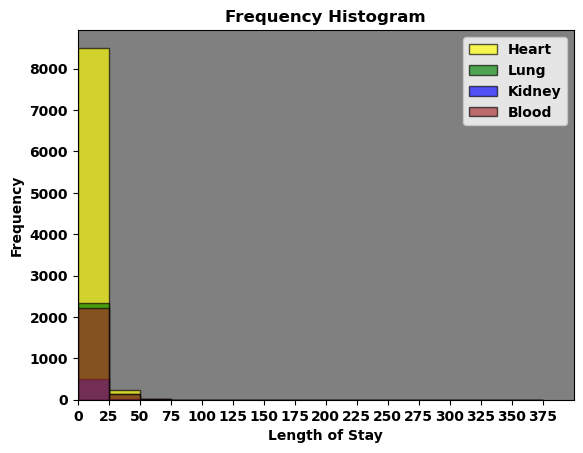

In [31]:
# I need to change this so that the icd global table incoroprates color
# Plot stay times for each admision by diagnosis code
pd.set_option('display.max_rows', 50)
# intestinal_adms[1:5]
intestinal_adms = intestinal_adms.dropna(subset=['primary_icd10_code', 'icd_category'])

icd_codes2 = {'Heart':'yellow','Lung':'green', 'Kidney':'blue', 'Blood':'brown'}

abins = range(0,400,25)
kwargs = dict(alpha=0.65, bins=abins)
ax = plt.axes(alpha=0)
ax.set_facecolor("grey")

temp_vert = 100

for code, description in icd_codes2.items():
#    print('data: ', code, ' ' , description)
    temp_x = intestinal_adms.loc[intestinal_adms['icd_category'].str.contains(code), 'stay_days']
#    print('size: ', len(temp_x))
    ax.hist(temp_x, **kwargs, color=description, edgecolor='black', label=code)
    ax.set_xticks(range(0,400,25))
    temp_text = ' N = ' + str(len(temp_x))
    temp_vert -= 2


plt.gca().set(title='Frequency Histogram', ylabel='Frequency', xlabel='Length of Stay');
plt.xlim(0,400)
plt.legend()
plt.show()

<div class="alert alert-block alert-success"><font color="black"><h2><left>Examine Largest Diagnosis Codes in Side-By-Side Charts</left>
</h2></font>

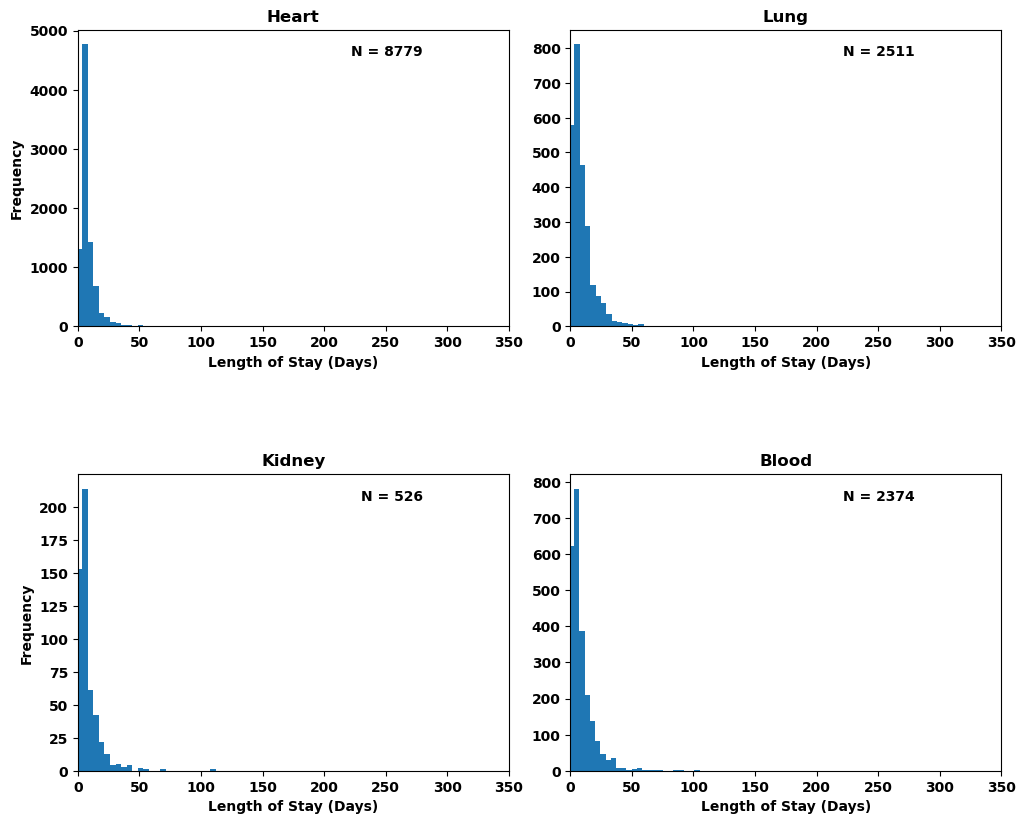

In [32]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
abins = range(25,300,25)
kwargs = dict(alpha=0.65, bins=abins)


x_row = 0
x_col = 0

for code, description in icd_codes2.items():
    
    temp_x = intestinal_adms.loc[intestinal_adms['icd_category'].str.contains(code), 'stay_days']
    
    atext = 'N = ' + str(len(temp_x))
    axis[x_row,x_col].hist(temp_x, bins=25)
    axis[x_row,x_col].set_xlim(0,200)
    xtitle = code
    # xtitle = code + ' ' + description
    axis[x_row,x_col].text(0.8, 0.95, atext, horizontalalignment='right', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].set_xticks(range(0,400,50))
    axis[x_row,x_col].set_title(xtitle)
    axis[x_row,x_col].set_xlabel('Length of Stay (Days)')
    if x_col == 0:
        axis[x_row,x_col].set_ylabel('Frequency')
        x_col += 1
    else:
        x_row += 1
        x_col = 0
        
        
        

<div class="alert alert-block alert-success"><font color="black"><h2><left>Examine Largest Diagnosis Codes Boxplots</left>
</h2></font>

Categ: Heart 	 Min: -1, Q1: 4.0, Median: 6.0, Q3: 10.0, Max: 112
Categ: Lung 	 Min: -1, Q1: 4.0, Median: 7.0, Q3: 12.0, Max: 107
Categ: Kidney 	 Min: -1, Q1: 3.0, Median: 5.0, Q3: 10.0, Max: 112
Categ: Blood 	 Min: -1, Q1: 3.0, Median: 6.0, Q3: 11.0, Max: 105


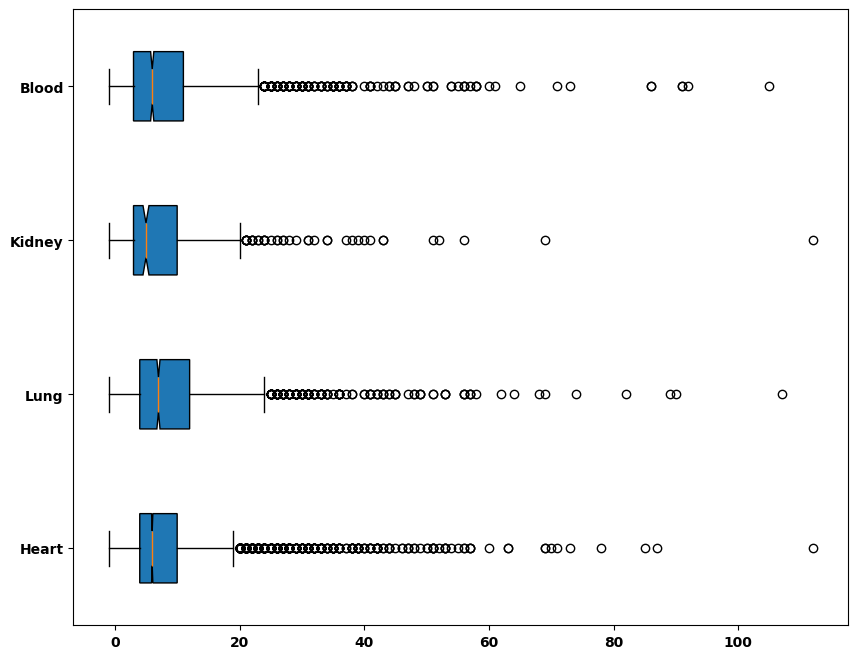

In [33]:

fig = plt.figure(figsize =(10, 8))
ax = fig.add_subplot(111)

def get_5_point_summary(categ, data):
    
    # calculate a 5-number summary
    from numpy import percentile
    from numpy.random import rand
    # calculate quartiles
    quartiles = percentile(data, [25, 50, 75])
    # calculate min/max
    data_min, data_max = data.min(), data.max()
    # print 5-number summary
    print('Categ: {0} \t Min: {1}, Q1: {2}, Median: {3}, Q3: {4}, Max: {5}'
          .format(code, data_min, quartiles[0], quartiles[1], quartiles[2], data_max))
    return
    
 
def get_data(code):
    
#    temp_x = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains(code), 'stay_days']

    temp_x = intestinal_adms.loc[intestinal_adms['icd_category'].str.contains(code,na=False), 'stay_days']
    return temp_x

x_data = []
x_description = []
x_items = 0

#for code, description in icd_codes_t.items():
for code, description in icd_codes2.items():
    #print(code, description)
    x_description.append(code)
    temp_data = get_data(code)
    get_5_point_summary(code, temp_data)      
    x_data.append(temp_data)
    

# Creating axes instance
bp = ax.boxplot(x_data, patch_artist = True,
                notch ='True', vert = 0)

ax.set_yticklabels(x_description)

fig.savefig('E:/Education/CCSU-Thesis-2024/Data/Images/icd_categ_bplot.png')

temp len: 2069
ICD10: A41.9 	 Min: -1, Q1: 3.0, Median: 6.0, Q3: 11.0, Max: 105
temp len: 1751
ICD10: I21.4 	 Min: -1, Q1: 4.0, Median: 7.0, Q3: 11.0, Max: 87
temp len: 3498
ICD10: I25.10 	 Min: 0, Q1: 5.0, Median: 6.0, Q3: 9.0, Max: 69
temp len: 1140
ICD10: I35.2 	 Min: 1, Q1: 5.0, Median: 7.0, Q3: 10.0, Max: 112
temp len: 570
ICD10: I50.9 	 Min: 0, Q1: 5.0, Median: 8.0, Q3: 13.0, Max: 73
temp len: 1127
ICD10: J96.00 	 Min: -1, Q1: 4.0, Median: 7.0, Q3: 13.0, Max: 107
temp len: 526
ICD10: N17.9 	 Min: -1, Q1: 3.0, Median: 5.0, Q3: 10.0, Max: 112


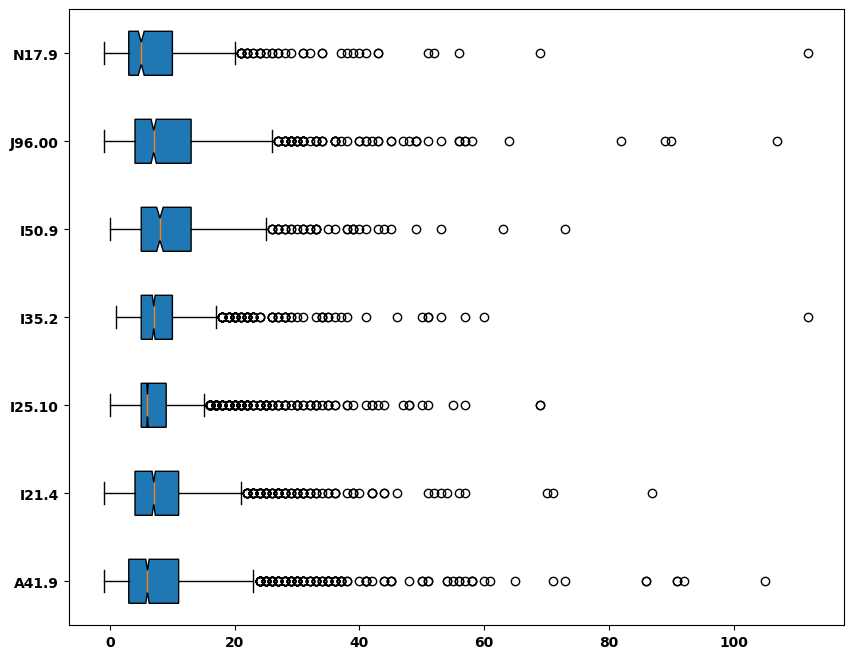

In [34]:

fig = plt.figure(figsize =(10, 8))
ax = fig.add_subplot(111)

good_list = ["A41.9","I21.4","I25.10","I35.2","I50.9","J96.00","N17.9"]
good_diags_df = pd.DataFrame(good_list, columns=['icd10_code'])

def get_5_point_summary(categ, data):
    
    # calculate a 5-number summary
    from numpy import percentile
    from numpy.random import rand
    # calculate quartiles
    quartiles = percentile(data, [25, 50, 75])
    # calculate min/max
    data_min, data_max = data.min(), data.max()
    # print 5-number summary
    print('ICD10: {0} \t Min: {1}, Q1: {2}, Median: {3}, Q3: {4}, Max: {5}'
          .format(code, data_min, quartiles[0], quartiles[1], quartiles[2], data_max))
    return
    
 
def get_data(code):
    
#    temp_x = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains(code), 'stay_days']

    temp_x = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains(code,na=False), 'stay_days']
    return temp_x

x_data = []
x_description = []
x_items = 0

#for code, description in icd_codes_t.items():
for code in good_list:
    #print(code, description)
    x_description.append(code)
    temp_data = get_data(code)
    print('temp len:', len(temp_data))
    get_5_point_summary(code, temp_data)      
    x_data.append(temp_data)
    

# Creating axes instance
bp = ax.boxplot(x_data, patch_artist = True,
                notch ='True', vert = 0)

ax.set_yticklabels(x_description)

fig.savefig('E:/Education/CCSU-Thesis-2024/Data/Images/icd10_bplot.png')

<div class="alert alert-block alert-success"><font color="black"><h2><left>Compare the LOS for Emergency vs Elective</left>
</h2></font>

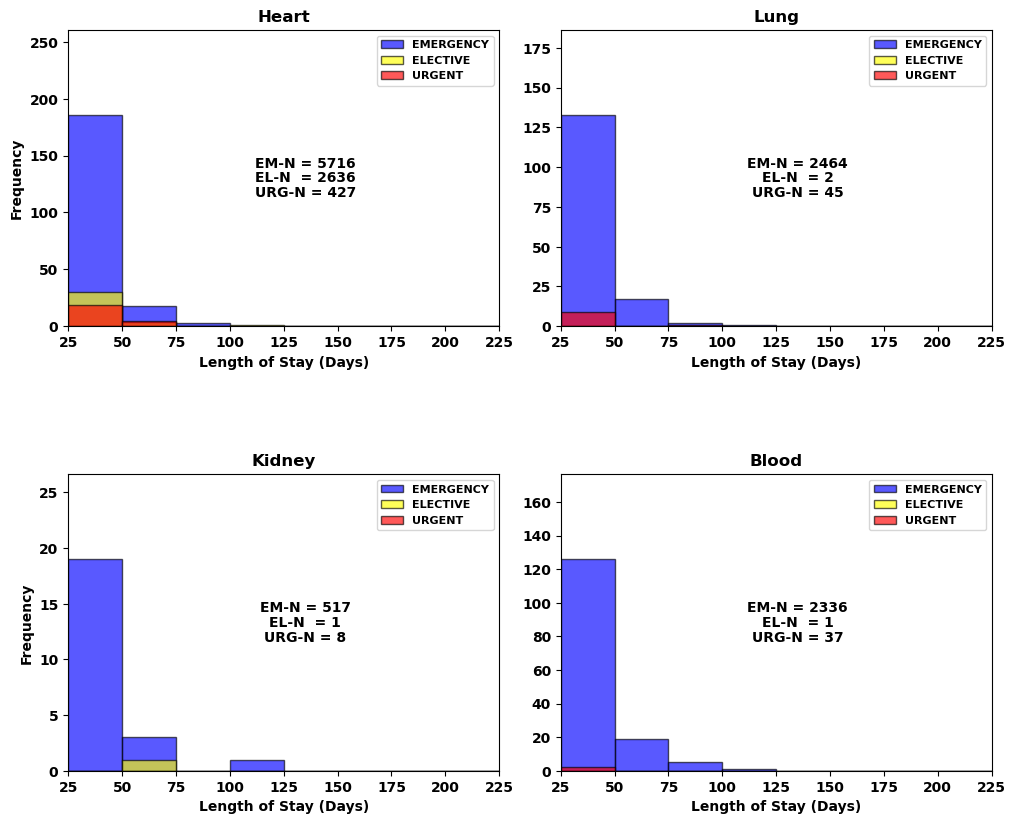

In [35]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
abins = range(25,250,25)
kwargs = dict(alpha=0.65, bins=abins)

x_row = 0
x_col = 0

for code, description in icd_codes2.items():
    
#   xem = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
    xem = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &                              
    (intestinal_adms['admission_type'] == 'EMERGENCY'),'stay_days']
#   xel = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
    xel = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &                              
    (intestinal_adms['admission_type'] == 'ELECTIVE'),'stay_days']
#    xur = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
    xur = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &                              
    (intestinal_adms['admission_type'] == 'URGENT'),'stay_days']
    

    atext = 'EM-N = ' + str(len(xem))
    btext = 'EL-N  = ' + str(len(xel))
    ctext = 'URG-N = ' + str(len(xur))

    
    axis[x_row,x_col].hist(xem, **kwargs, color='blue', edgecolor='black',label='EMERGENCY')
    axis[x_row,x_col].hist(xel, **kwargs, color='yellow', edgecolor='black',label='ELECTIVE')
    axis[x_row,x_col].hist(xur, **kwargs, color='red', edgecolor='black',label='URGENT')
    
    # xtitle = code + ' ' + description
    xtitle = code
    axis[x_row,x_col].text(0.55, 0.55, atext, horizontalalignment='center', verticalalignment='center', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.55, 0.50, btext, horizontalalignment='center', verticalalignment='center', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.55, 0.45, ctext, horizontalalignment='center', verticalalignment='center', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].set_xlabel('Length of Stay (Days)')
    
    axis[x_row,x_col].legend(fontsize="8")
    axis[x_row,x_col].set_title(xtitle)
    axis[x_row,x_col].margins(0,0.40)    
    if x_col == 0:
        axis[x_row,x_col].set_ylabel('Frequency')
        x_col += 1
    else:
        x_row += 1
        x_col = 0
    


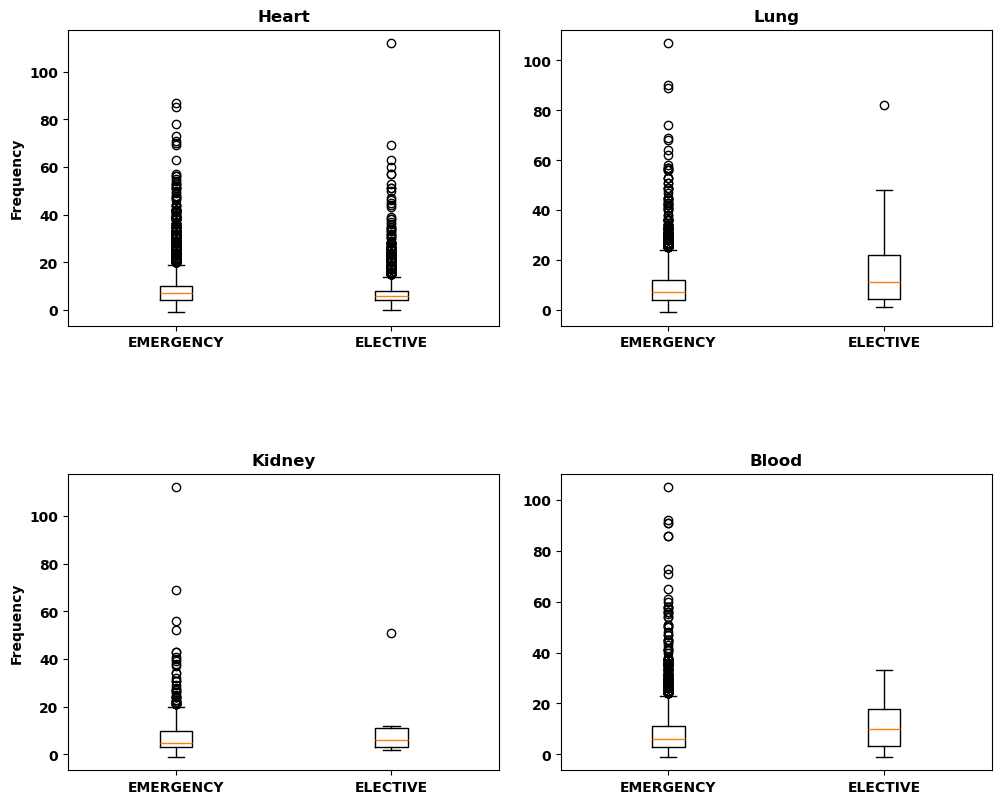

In [36]:
figure, axis = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
# abins = range(25,800,25)
# kwargs = dict(alpha=0.65, bins=abins)

x_row = 0
x_col = 0

for code, description in icd_codes2.items():
    
    temp_xm = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &
                        (intestinal_adms['admission_type'] == 'EMERGENCY'),'stay_days']
    temp_xs = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &
                        (intestinal_adms['admission_type'] != 'EMERGENCY'),'stay_days']
    temp_data = [temp_xm, temp_xs]
    axis[x_row,x_col].boxplot(temp_data)
    xtitle = code
    axis[x_row,x_col].set_title(xtitle)
    axis[x_row,x_col].set_xticklabels(['EMERGENCY', 'ELECTIVE'])
    if x_col == 0:
        axis[x_row,x_col].set_ylabel('Frequency')
        x_col += 1
    else:
        x_row += 1
        x_col = 0


In [37]:
#intestinal_adms.columns
intestinal_adms[['icd_category']].groupby(['icd_category'])\
                                 .size().reset_index(name='Total')\
                                 .sort_values('Total', ascending=False)
#df.groupby(["Group", "Size"]).size().reset_index(name="Time").sort_values()
# intestinal_adms

,icd_category,Total
2,Heart,8779
4,Lungs,2511
0,Blood,2374
1,Brain,1559
3,Kidney,526


In [38]:
#intestinal_adms.columns
ethnicity_adms = intestinal_adms[['ethnicity','icd_category']].groupby(['ethnicity','icd_category'])\
                                                                    .size().reset_index(name='Total')\
                                                                    .sort_values(['icd_category', 'ethnicity'], ascending=[True,False])
#df.groupby(["Group", "Size"]).size().reset_index(name="Time").sort_values()
ethnicity_adms

,ethnicity,icd_category,Total
135,WHITE - RUSSIAN,Blood,13
130,WHITE - OTHER EUROPEAN,Blood,5
120,WHITE,Blood,1736
115,UNKNOWN/NOT SPECIFIED,Blood,107
110,UNABLE TO OBTAIN,Blood,40
...,...,...,...
35,ASIAN - VIETNAMESE,Lungs,2
24,ASIAN - FILIPINO,Lungs,1
20,ASIAN - CHINESE,Lungs,18
12,ASIAN - ASIAN INDIAN,Lungs,1


<div class="alert alert-block alert-success"><font color="black"><h2><left>Examine Ethnicity</left>
</h2></font>

In [39]:
def set_ethnic_group(ethnicity):
    if 'WHITE' in ethnicity:
        return 'W'
    elif 'BLACK' in ethnicity:
        return 'B'
    elif 'UNKNOWN' in ethnicity:
        return 'U'
    elif 'DECLINE' in ethnicity:
        return 'U'
    elif 'UNABLE' in ethnicity:
        return 'U'
    elif 'ASIAN' in ethnicity:
        return 'A'
    elif 'HISPANIC' in ethnicity:
        return 'H'
    elif 'NATIVE' in ethnicity:
        return 'I'
    elif 'CARIBBEAN' in ethnicity:
        return 'B'
    elif 'AMERICAN INDIAN' in ethnicity:
        return 'I'
    elif 'PORTUGUESE' in ethnicity:
        return 'H'
    elif 'MIDDLE EASTERN' in ethnicity:
        return 'M'
    elif 'SOUTH AMERICAN' in ethnicity:
        return 'H'
    else:
        return 'O'


# df['add'] = df.apply(lambda row : add(row['A'], row['B'], row['C']), axis = 1)    
intestinal_adms['ethnic_group'] = intestinal_adms.apply(lambda row: set_ethnic_group(row['ethnicity']), axis = 1)


In [40]:
intestinal_adms.shape 

(15749, 18)

In [41]:
#intestinal_adms.groupby(['ethnic_group','ethnicity'])['hadm_id'].count() 

In [42]:
# Testing Ethnicity
intestinal_adms.groupby('ethnic_group').size().reset_index(name='Total')

,ethnic_group,Total
0,A,346
1,B,1181
2,H,447
3,I,11
4,M,12
5,O,332
6,U,2236
7,W,11184


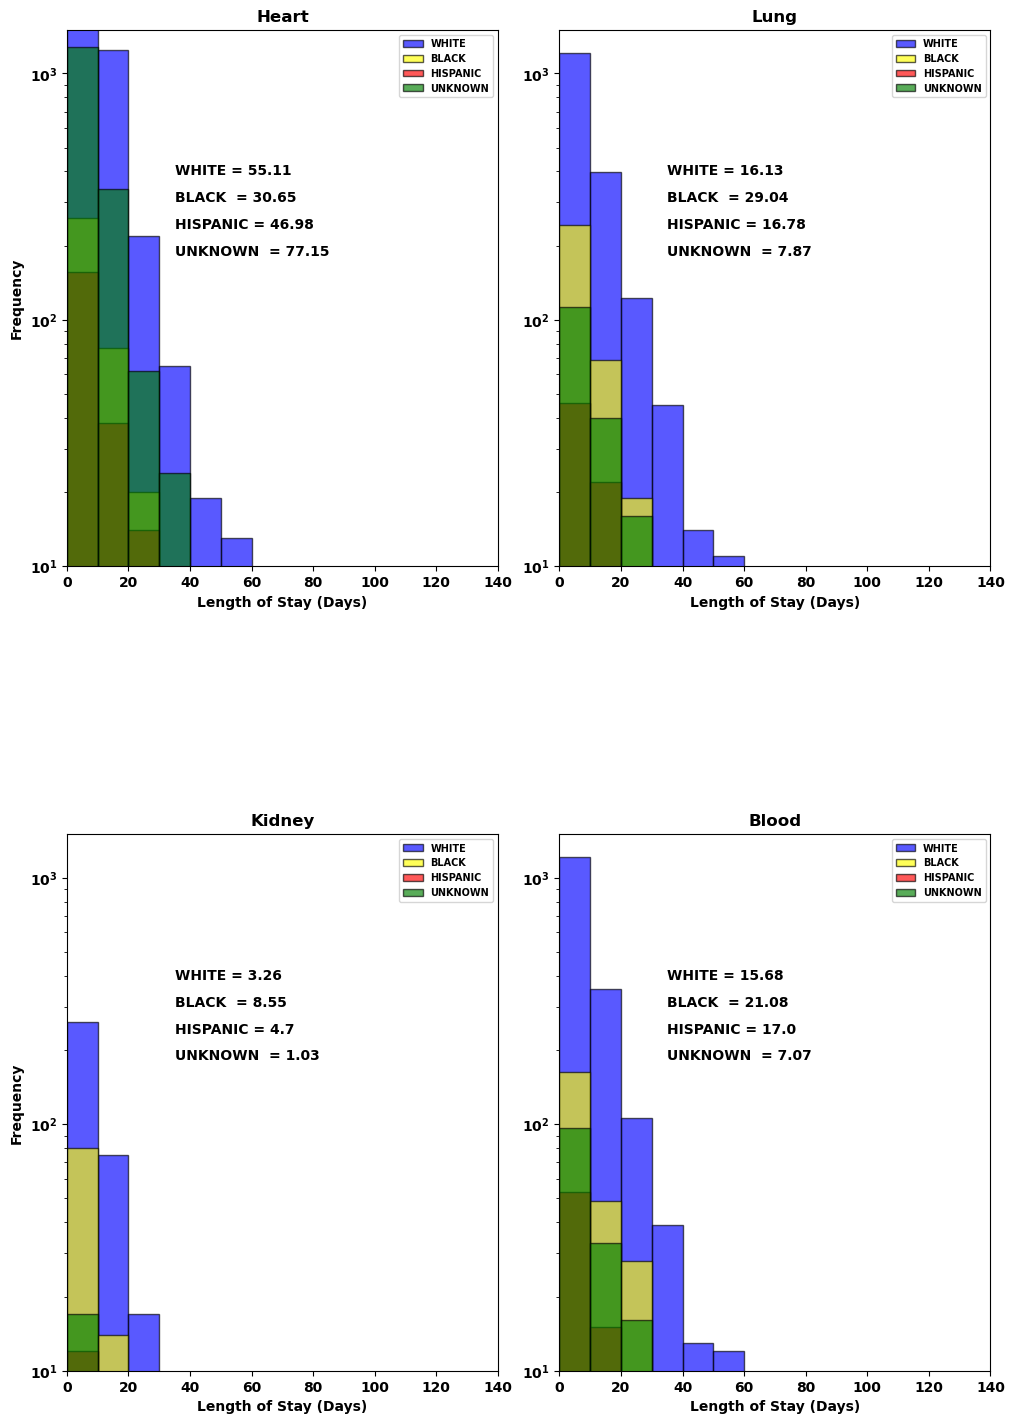

In [43]:
# Compare Length of Stay and Ethnicity
# Initialize the subplot function using number of rows and columns
figure, axis = plt.subplots(nrows=2, ncols=2, figsize=(10, 14))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
abins = range(0,250,10)
kwargs = dict(alpha=0.65, bins=abins)

x_row = 0
x_col = 0

for code, description in icd_codes2.items():
        
    temp_xw = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'W'),'stay_days']
    temp_xb = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'B'),'stay_days']
    temp_xh = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'H'),'stay_days']
    temp_xu = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'U'),'stay_days']
  #  temp_xo = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
  #                      (intestinal_adms['ethnic_group'] in ['O','A','I','M']),'stay_days']
    
    wn = len(temp_xw)
    bn = len(temp_xb)
    hn = len(temp_xh)
    un = len(temp_xu)
  #  on = len(temp_xo)
    
    twn = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'W')])
    tbn = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'B')])
    thn = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'H')])
    tun = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'U')])
    #max_y = max(pd.concat([temp_xu, temp_xw, temp_xh, temp_xb]))
     
    atext = 'WHITE = ' + str(round((len(temp_xw)/twn)*100,2))
    btext = 'BLACK  = ' + str(round((len(temp_xb)/tbn)*100,2))
    ctext = 'HISPANIC = ' + str(round((len(temp_xh)/thn)*100,2))
    dtext = 'UNKNOWN  = ' + str(round((len(temp_xu)/tun)*100,2))
 #   etext = 'OTHER = ' + str(len(temp_xo))
    
    axis[x_row,x_col].set_yscale("log") 
    axis[x_row,x_col].set_ylim(10, 1500)
    #axis[x_row,x_col].autoscale(enable=False)
    axis[x_row,x_col].set_xlim(0, 120)
    axis[x_row,x_col].hist(temp_xw, **kwargs, color='blue', edgecolor='black',label='WHITE')
    axis[x_row,x_col].hist(temp_xb, **kwargs, color='yellow', edgecolor='black',label='BLACK')
    axis[x_row,x_col].hist(temp_xh, **kwargs, color='red', edgecolor='black',label='HISPANIC')
    axis[x_row,x_col].hist(temp_xu, **kwargs, color='green', edgecolor='black',label='UNKNOWN')
   # axis[x_row,x_col].hist(temp_xo, **kwargs, color='purple', edgecolor='black',label='OTHER')
    xtitle = code
    axis[x_row,x_col].text(0.25, 0.75, atext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.25, 0.70, btext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.25, 0.65, ctext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.25, 0.60, dtext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    # axis[x_row,x_col].text(0.35, 0.55, etext, horizontalalignment='center', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    
    axis[x_row,x_col].set_xlabel('Length of Stay (Days)')
    axis[x_row,x_col].legend(fontsize="7")
    axis[x_row,x_col].set_title(xtitle)
    axis[x_row,x_col].set_xticks(np.arange(0,160, 20.0))
    
    axis[x_row,x_col].margins(0,0.45)    
    if x_col == 0:
        axis[x_row,x_col].set_ylabel('Frequency')
        x_col += 1
    else:
        x_row += 1
        x_col = 0
    
    figure.savefig('E:/Education/CCSU-Thesis-2024/Data/Images/ethnicity_plot2.png', dpi=300)
    #axis[1,1].set_axis_off()


C:\Users\rolan\AppData\Local\Temp\ipykernel_34680\2918240569.py:56: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axis[x_row,x_col].set_ylim([0,1000])


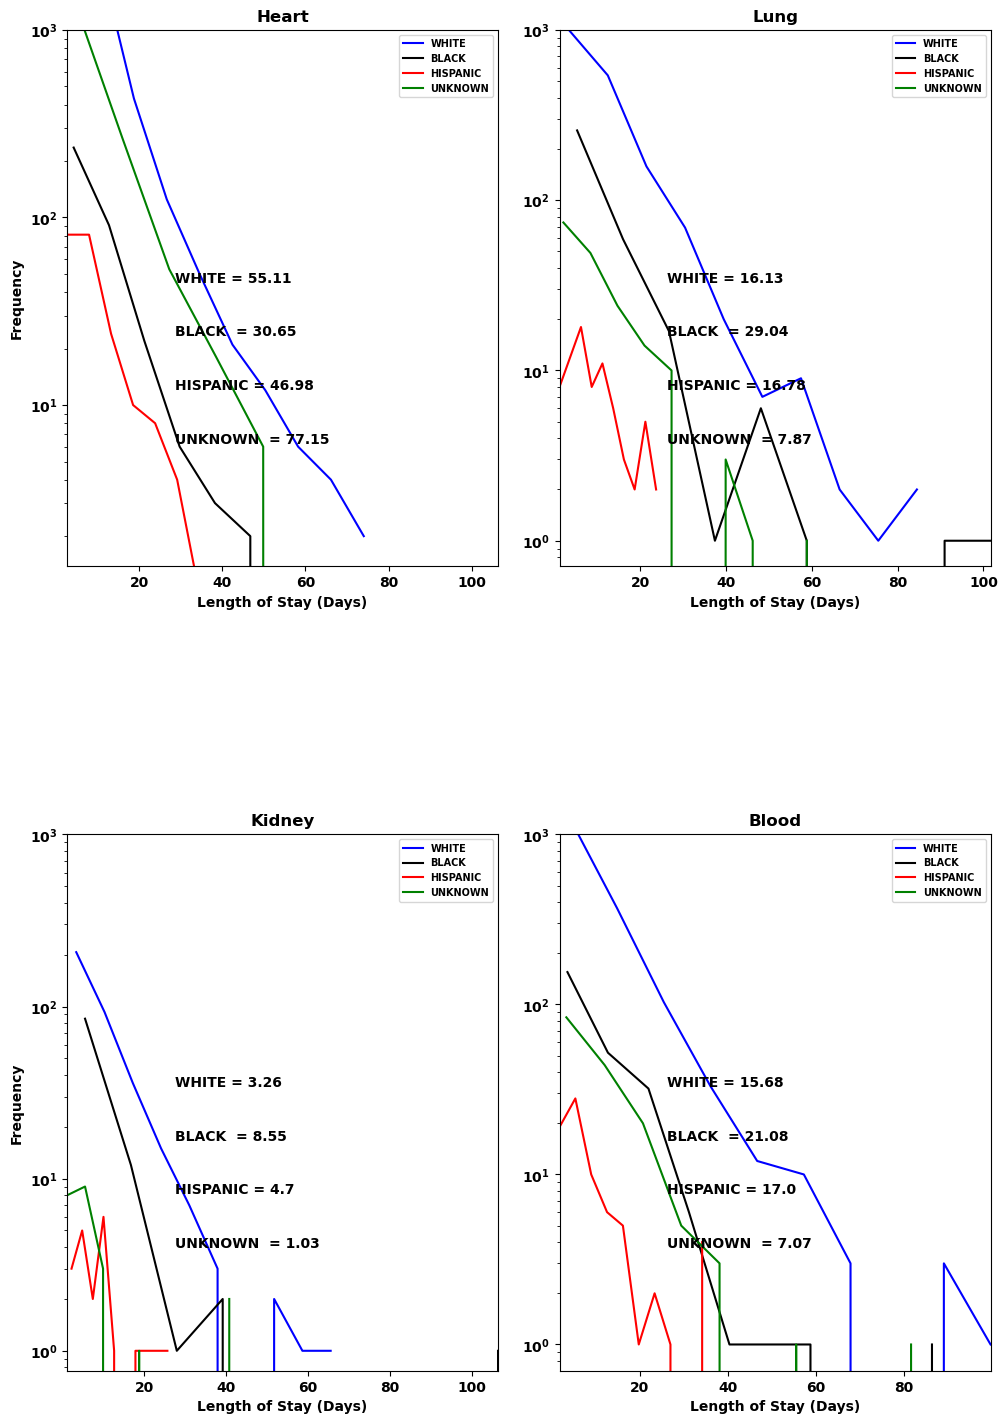

In [44]:
# Compare Length of Stay and Ethnicity
# Initialize the subplot function using number of rows and columns
import numpy as np
import pylab as p
figure, axis = plt.subplots(nrows=2, ncols=2, figsize=(10, 14))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
abins = range(0,250,10)
kwargs = dict(alpha=0.65, bins=abins)

x_row = 0
x_col = 0

for code, description in icd_codes2.items():
        
    temp_xw = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'W'),'stay_days']
    temp_xb = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'B'),'stay_days']
    temp_xh = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'H'),'stay_days']
    temp_xu = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'U'),'stay_days']
  #  temp_xo = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
  #                      (intestinal_adms['ethnic_group'] in ['O','A','I','M']),'stay_days']
    
    wn = len(temp_xw)
    bn = len(temp_xb)
    hn = len(temp_xh)
    un = len(temp_xu)
  #  on = len(temp_xo)
    
    twn = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'W')])
    tbn = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'B')])
    thn = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'H')])
    tun = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'U')])
    #max_y = max(pd.concat([temp_xu, temp_xw, temp_xh, temp_xb]))
     
    atext = 'WHITE = ' + str(round((len(temp_xw)/twn)*100,2))
    btext = 'BLACK  = ' + str(round((len(temp_xb)/tbn)*100,2))
    ctext = 'HISPANIC = ' + str(round((len(temp_xh)/thn)*100,2))
    dtext = 'UNKNOWN  = ' + str(round((len(temp_xu)/tun)*100,2))
 #   etext = 'OTHER = ' + str(len(temp_xo))
    
     
    
    #data=np.array(np.random.rand(1000))
    xw_y,xw_binEdges=np.histogram(temp_xw,bins=10)
    xw_bincenters = 0.5*(xw_binEdges[1:]+xw_binEdges[:-1])
    axis[x_row,x_col].plot(xw_bincenters,xw_y,'-', color='blue', label='WHITE')
    xb_y,xb_binEdges=np.histogram(temp_xb,bins=10)
    xb_bincenters = 0.5*(xb_binEdges[1:]+xb_binEdges[:-1])
    axis[x_row,x_col].set_yscale("log")
    axis[x_row,x_col].set_ylim([0,1000])
    axis[x_row,x_col].plot(xb_bincenters,xb_y,'-', color='black', label='BLACK')
    xh_y,xh_binEdges=np.histogram(temp_xh,bins=10)
    xh_bincenters = 0.5*(xh_binEdges[1:]+xh_binEdges[:-1])
    axis[x_row,x_col].plot(xh_bincenters,xh_y,'-', color='red', label='HISPANIC')
    xu_y,xu_binEdges=np.histogram(temp_xu,bins=10)
    xu_bincenters = 0.5*(xu_binEdges[1:]+xu_binEdges[:-1])
    axis[x_row,x_col].plot(xu_bincenters,xu_y,'-', color='green', label='UNKNOWN')
    #axis[x_row,x_col].hist(temp_xu, **kwargs, color='green', edgecolor='black',label='UNKNOWN', histtype='step')
   # axis[x_row,x_col].hist(temp_xo, **kwargs, color='purple', edgecolor='black',label='OTHER', histtype='step')
    xtitle = code
    axis[x_row,x_col].text(0.25, 0.55, atext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.25, 0.45, btext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.25, 0.35, ctext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.25, 0.25, dtext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    # axis[x_row,x_col].text(0.35, 0.55, etext, horizontalalignment='center', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    
    axis[x_row,x_col].set_xlabel('Length of Stay (Days)')
    axis[x_row,x_col].legend(fontsize="7")
    axis[x_row,x_col].set_title(xtitle)
    axis[x_row,x_col].set_xticks(np.arange(0,160, 20.0))
    #axis[x_row,x_col].set_yticks(np.arange(0, 300, 20.0))
    #axis[x_row,x_col].set_yticks(np.arange(0, max_y, round(max_y*.10)))
    #print(max_y, round(max_y * .10))
    #print(np.arange(0, max_y, round(max_y*.10)))
    axis[x_row,x_col].margins(0,0.45)    
    if x_col == 0:
        axis[x_row,x_col].set_ylabel('Frequency')
        x_col += 1
    else:
        x_row += 1
        x_col = 0
    
    #fig.delaxes(axis[1][1])
    #axis[1,1].set_axis_off()


In [45]:
# patients with more than one admission
# 10% intestinal folks have more than one admission
gt2admin = intestinal_adms.groupby(['subject_id', ])['hadm_id'].count() \
              .reset_index(name='count') \
              .sort_values(['count'], ascending=False)

counts = gt2admin.loc[gt2admin['count'] > 1]['count']
print('totals: ', sum(gt2admin['count']), ' number: ', len(counts))

totals:  15749  number:  1189


In [46]:
# Count admissions by primary diagnosis
icd10_counts = intestinal_adms.groupby(['primary_icd10_code','primary_icd9_code']).agg(Totals=('hadm_id', 'nunique')).reset_index('primary_icd10_code')\
                  .sort_values(['Totals'], ascending=False)
icd10_count_details = pd.merge(icd10_counts, diag_codes, left_on='primary_icd9_code', right_on='icd9_code',)\
                      [['primary_icd10_code', 'icd9_code', 'long_title', 'Totals']]
print('total admissions: ', sum(icd10_count_details['Totals']), ' total codes: ', icd10_count_details.shape[0])
icd10_counts[0:20]
#icd10_count_details[0:20]

total admissions:  15749  total codes:  16


,primary_icd10_code,Totals
primary_icd9_code,,
41401,I25.10,3498
0389,A41.9,2069
41071,I21.4,1751
4241,I35.2,1140
51881,J96.00,1127
431,I61.9,1030
486,J18.9,725
5070,J69.0,659
4280,I50.9,570


In [47]:
intestinal_adms.isnull().sum()

index                     0
subject_id                0
hadm_id                   0
primary_icd9_code         0
primary_icd10_code        0
icd_category              0
stay_days                 0
admission_type            0
admittime                 0
dischtime                 0
deathtime             13648
insurance                 0
language               6236
religion                187
marital_status          714
ethnicity                 0
diagnosis                 2
ethnic_group              0
dtype: int64

In [48]:
# This identifies that 52 admissions do not have discharge notes
import pandasql as ps

qints99 = intestinal_adms[['primary_icd10_code', 'hadm_id', 'icd_category']]
# print(qintsl.dtypes)
q1 = """SELECT icd_category, count(distinct hadm_id) FROM qints99 a where primary_icd10_code = 'I35.2' group by icd_category"""  

p1 = ps.sqldf(q1, locals())
#print(len(np.unique(p1.)))
print(p1)

  icd_category  count(distinct hadm_id)
0        Heart                     1140


In [49]:
# wanted_icd10_codes = ['K21.9', 'K25.0','K25.4','K29.90','K29.91','K51.00','K51.90','K56.60', 'K56.69','K52.9',
#                      'K52.30','K52.31','K52.32','I27.89','K58.9', 'K92.2']

wanted_icd_categories99 = ['Lungs', 'Heart','Kidney', 'Blood']

spec_intel_adms = intestinal_adms.loc[intestinal_adms['icd_category'].isin(wanted_icd_categories99)]
print(len(spec_intel_adms), len(intestinal_adms))

14190 15749


In [50]:
#intestinal_adms.groupby('primary_icd10_code')['hadm_id'].nunique()
spec_intel_adms.groupby('primary_icd10_code')['hadm_id'].nunique()

primary_icd10_code
A41.51     305
A41.9     2069
I21.09     482
I21.19     482
I21.4     1751
I25.10    3498
I34.0      568
I35.2     1140
I50.23     288
I50.9      570
J18.9      725
J69.0      659
J96.00    1127
N17.9      526
Name: hadm_id, dtype: int64

In [51]:
# Count admissions by primary diagnosis
spec_intel_adms['primary_icd9_code'] =  spec_intel_adms['primary_icd9_code'].astype('string') 
icd10_countsb = spec_intel_adms.groupby(['primary_icd10_code','primary_icd9_code'])['hadm_id'].nunique() \
              .reset_index(name='count') \
              .sort_values(['count'], ascending=False)
#icd10_count_detailsb = pd.merge(icd10_countsb, diag_codes, left_on='primary_icd9_code', right_on='icd9_code')\
#                      [['primary_icd10_code', 'icd9_code', 'long_title', 'count']]
icd10_countsb

C:\Users\rolan\AppData\Local\Temp\ipykernel_34680\47374516.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spec_intel_adms['primary_icd9_code'] =  spec_intel_adms['primary_icd9_code'].astype('string')


,primary_icd10_code,primary_icd9_code,count
5,I25.10,41401,3498
1,A41.9,0389,2069
4,I21.4,41071,1751
7,I35.2,4241,1140
12,J96.00,51881,1127
10,J18.9,486,725
11,J69.0,5070,659
9,I50.9,4280,570
6,I34.0,4240,568
13,N17.9,5849,526


In [52]:
# if roland == ready:
#    print(got here)

<div class="alert alert-block alert-success"><font color="black"><h1><left>
Include Notes to Admissions for the Intestinal Conditions</left></h1></font>

- Include only Nurse and Physician Notes
- Inclue Only Emergency and Urgent Admissions
- Format admittime and chartdate as dates
- Put aside discharge notes</div>

In [53]:
spec_intel_adms[1:5]

,index,subject_id,hadm_id,primary_icd9_code,primary_icd10_code,icd_category,stay_days,admission_type,admittime,dischtime,deathtime,insurance,language,religion,marital_status,ethnicity,diagnosis,ethnic_group
2,2,13,143045,41401,I25.10,Heart,6,EMERGENCY,2167-01-08 18:43:00,2167-01-15 15:15:00,NaT,Medicaid,None,OTHER,None,WHITE,CORONARY ARTERY DISEASE,W
3,3,20,157681,41401,I25.10,Heart,5,ELECTIVE,2183-04-28 09:45:00,2183-05-03 14:45:00,NaT,Medicare,None,CATHOLIC,WIDOWED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,W
4,4,21,109451,41071,I21.4,Heart,13,EMERGENCY,2134-09-11 12:17:00,2134-09-24 16:15:00,NaT,Medicare,None,JEWISH,MARRIED,WHITE,CONGESTIVE HEART FAILURE,W
5,5,23,152223,41401,I25.10,Heart,5,ELECTIVE,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,Medicare,None,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,W


In [54]:
# get nurses and physician notes

notes = pd.read_parquet(file4,engine='auto',dtype_backend='numpy_nullable')

In [55]:
# For some reason, the physician category has a space at the end!' 
sel_categories = ['Nursing/other','Nursing','Discharge summary', 'Physician ']
pn_notes = notes.loc[notes['category'].isin(sel_categories)]
# pn_notes = notes 
print('selected notes: ', pn_notes.shape)
print(pn_notes.shape)
notes.groupby('category')['hadm_id'].count()

selected notes:  (1247329, 11)
(1247329, 11)


category
Case Management         954
Consult                  98
Discharge summary     59652
ECG                  138190
Echo                  34037
General                8209
Nursing              220758
Nursing/other        821258
Nutrition              9378
Pharmacy                102
Physician            140100
Radiology            378920
Rehab Services         5409
Respiratory           31667
Social Work            2612
Name: hadm_id, dtype: Int64

In [56]:
# remove newborn and elective admissions
wanted_adm_types = ['EMERGENCY', 'URGENT']
spec_intel_adms = spec_intel_adms.loc[spec_intel_adms['admission_type'].isin(wanted_adm_types)]
print('admission subset: ', spec_intel_adms.shape)
#spec_intel_adms.groupby('admission_type')['hadm_id'].nunique()
spec_intel_adms.groupby(['primary_icd10_code', 'admission_type'])['hadm_id'].nunique()[10:30]

admission subset:  (11550, 18)


primary_icd10_code  admission_type
I25.10              EMERGENCY         1946
                    URGENT             157
I34.0               EMERGENCY          145
                    URGENT              13
I35.2               EMERGENCY          344
                    URGENT              19
I50.23              EMERGENCY          274
                    URGENT               8
I50.9               EMERGENCY          493
                    URGENT              37
J18.9               EMERGENCY          720
                    URGENT               5
J69.0               EMERGENCY          649
                    URGENT               9
J96.00              EMERGENCY         1095
                    URGENT              31
N17.9               EMERGENCY          517
                    URGENT               8
Name: hadm_id, dtype: int64

In [57]:
spec_intel_adms.groupby('primary_icd10_code')['hadm_id'].nunique()

primary_icd10_code
A41.51     305
A41.9     2068
I21.09     481
I21.19     482
I21.4     1744
I25.10    2103
I34.0      158
I35.2      363
I50.23     282
I50.9      530
J18.9      725
J69.0      658
J96.00    1126
N17.9      525
Name: hadm_id, dtype: int64

In [58]:
# put discharge notes aside
discharge_notes = pn_notes.loc[pn_notes['category'] == 'Discharge summary']
discharge_notes = discharge_notes.sort_values(by=['subject_id','hadm_id','chartdate'])
discharge_notes = pd.merge(spec_intel_adms, discharge_notes, on=['subject_id','hadm_id'])
print('discharge notes: ', discharge_notes.shape)

discharge notes:  (12833, 27)


In [59]:
spec_intel_adms.groupby('primary_icd10_code')['hadm_id'].nunique()

primary_icd10_code
A41.51     305
A41.9     2068
I21.09     481
I21.19     482
I21.4     1744
I25.10    2103
I34.0      158
I35.2      363
I50.23     282
I50.9      530
J18.9      725
J69.0      658
J96.00    1126
N17.9      525
Name: hadm_id, dtype: int64

In [60]:
spec_intel_adms.hadm_id = spec_intel_adms.hadm_id.astype('Int64')
pn_notes.hadm_id = pn_notes.hadm_id.astype('Int64')
# Sort by subject_ID, HAD_ID then CHARTDATE
pn_notes = pn_notes.sort_values(by=['subject_id','hadm_id','chartdate'])
# Merge notes table to admissions table
intsl_notes = pd.merge(spec_intel_adms, pn_notes[pn_notes['category']!= 'Discharge summary'],
                        on = ['subject_id','hadm_id'],
                        how = 'left')
print(intsl_notes.columns)
intsl_notes.shape

C:\Users\rolan\AppData\Local\Temp\ipykernel_34680\1608630043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pn_notes.hadm_id = pn_notes.hadm_id.astype('Int64')


Index(['index', 'subject_id', 'hadm_id', 'primary_icd9_code',
       'primary_icd10_code', 'icd_category', 'stay_days', 'admission_type',
       'admittime', 'dischtime', 'deathtime', 'insurance', 'language',
       'religion', 'marital_status', 'ethnicity', 'diagnosis', 'ethnic_group',
       'row_id', 'chartdate', 'charttime', 'storetime', 'category',
       'description', 'cgid', 'iserror', 'text'],
      dtype='object')


(201389, 27)

In [61]:
import pandasql as ps

qintsl5 = intsl_notes[['primary_icd10_code','subject_id','hadm_id']]
#qints2 = pn_notes[['subject_id', 'hadm_id']]
# print(qintsl.dtypes)
q10 = """SELECT a.primary_icd10_code, count(distinct a.hadm_id) FROM qintsl5 a 
        group by a.primary_icd10_code"""

#q19 = """SELECT a.primary_icd10_code, count(distinct a.hadm_id) FROM qintsl5 a 
#        where a.hadm_id in (select b.hadm_id from qints2 b) group by a.primary_icd10_code"""

p10 = ps.sqldf(q10, locals())
print(p10)


   primary_icd10_code  count(distinct a.hadm_id)
0              A41.51                        305
1               A41.9                       2068
2              I21.09                        481
3              I21.19                        482
4               I21.4                       1744
5              I25.10                       2103
6               I34.0                        158
7               I35.2                        363
8              I50.23                        282
9               I50.9                        530
10              J18.9                        725
11              J69.0                        658
12             J96.00                       1126
13              N17.9                        525


In [62]:
intsl_notes.groupby('primary_icd10_code')['hadm_id'].nunique()
#intsl_notes.groupby('category').count()

primary_icd10_code
A41.51     305
A41.9     2068
I21.09     481
I21.19     482
I21.4     1744
I25.10    2103
I34.0      158
I35.2      363
I50.23     282
I50.9      530
J18.9      725
J69.0      658
J96.00    1126
N17.9      525
Name: hadm_id, dtype: int64

In [63]:
len(intsl_notes.hadm_id.unique())

11550

In [64]:
import pandasql as ps

qintsl6 = intsl_notes[['subject_id', 'hadm_id']]
# print(qintsl.dtypes)
q1 = """SELECT distinct subject_id, hadm_id FROM qintsl6 """

p1 = ps.sqldf(q1, locals())
print(len(p1))


11550


In [65]:
# Grab date only, not the time
intsl_notes.admittime_c = intsl_notes.admittime.apply(lambda x: str(x).split(' ')[0])

intsl_notes['admittime_c'] = pd.to_datetime(intsl_notes.admittime_c, format = '%Y-%m-%d', errors = 'coerce')
intsl_notes['chartdate'] = pd.to_datetime(intsl_notes.chartdate, format = '%Y-%m-%d', errors = 'coerce')

C:\Users\rolan\AppData\Local\Temp\ipykernel_34680\2514053595.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  intsl_notes.admittime_c = intsl_notes.admittime.apply(lambda x: str(x).split(' ')[0])


In [66]:
intsl_notes.columns

Index(['index', 'subject_id', 'hadm_id', 'primary_icd9_code',
       'primary_icd10_code', 'icd_category', 'stay_days', 'admission_type',
       'admittime', 'dischtime', 'deathtime', 'insurance', 'language',
       'religion', 'marital_status', 'ethnicity', 'diagnosis', 'ethnic_group',
       'row_id', 'chartdate', 'charttime', 'storetime', 'category',
       'description', 'cgid', 'iserror', 'text', 'admittime_c'],
      dtype='object')

In [67]:
import pandasql as ps
def less_n_days_report(df_adm_notes, n):
    print('initial: ',len(df_adm_notes))
    df_less_n = df_adm_notes[
        ((df_adm_notes['chartdate'] - df_adm_notes['admittime_c']).dt.total_seconds() / (24 * 60 * 60)) < n]
    df_less_n = df_less_n[df_less_n['text'].notnull()]
    print('less_n: ',len(df_less_n))
    df_concat = pd.DataFrame(df_less_n.groupby(['subject_id','hadm_id'])['text'].apply(lambda x: "%s" % ' '.join(x))).reset_index()
    print('final: ',len(df_concat))
    df_concat['text'] = df_concat['text'].str.lstrip()
    df_concat['note_length'] = df_concat['text'].apply(len)
    compare_texts = pd.merge(df_less_n[['subject_id', 'hadm_id', 'text']], df_concat[['subject_id', 'hadm_id', 'note_length']], on = ['subject_id', 'hadm_id'],how = 'left')
    
    print(compare_texts.columns)
    qintsl7 = compare_texts[['subject_id', 'hadm_id', 'note_length', 'text']]
    
    q17 = """SELECT subject_id, hadm_id, note_length, sum(length(text)) FROM qintsl7 
            group by subject_id, hadm_id, note_length limit 10"""

    p17 = ps.sqldf(q17, locals())
    print(p17)
    return

In [68]:
intsl_notes.columns

Index(['index', 'subject_id', 'hadm_id', 'primary_icd9_code',
       'primary_icd10_code', 'icd_category', 'stay_days', 'admission_type',
       'admittime', 'dischtime', 'deathtime', 'insurance', 'language',
       'religion', 'marital_status', 'ethnicity', 'diagnosis', 'ethnic_group',
       'row_id', 'chartdate', 'charttime', 'storetime', 'category',
       'description', 'cgid', 'iserror', 'text', 'admittime_c'],
      dtype='object')

In [69]:
# This function selects notes within 3 days of admission date and merges them onto admission data
# it has been changed to return full set of columns of a concatenated notes admission
def less_n_days_data(df_adm_notes, selected_df, n):
    print('initial: ',len(df_adm_notes), df_adm_notes.columns)
    df_less_n = df_adm_notes[
        ((df_adm_notes['chartdate'] - df_adm_notes['admittime_c']).dt.total_seconds() / (24 * 60 * 60)) < n]
    print('less_n: ',len(df_less_n))
    df_less_n = df_less_n[df_less_n['text'].notnull()]
    print('less_n wo nulls: ',len(df_less_n))
    #print(df_less_n.columns)
    df_concat = pd.DataFrame(df_less_n.groupby(['subject_id','hadm_id'])['text'].apply(lambda x: "%s" % ' '.join(x))).reset_index()
    print('final adms with concatenated notes: ',len(df_concat))
    df_concat['text'] = df_concat['text'].str.lstrip()
    df_concat['note_length'] = df_concat['text'].apply(len)
    ccols = ['subject_id', 'hadm_id', 'primary_icd9_code',
       'primary_icd10_code', 'icd_category', 'stay_days', 'admission_type',
       'admittime', 'dischtime', 'deathtime', 'insurance', 'language',
       'religion', 'marital_status', 'ethnicity', 'diagnosis', 'ethnic_group']
    
    full_concat = pd.merge(df_concat, selected_df[ccols].drop_duplicates(), on=['subject_id', 'hadm_id'], how = 'inner')
    print(full_concat.columns)
    print('full concat: ',len(full_concat))
    return full_concat

In [70]:
# This function selects notes within 3 days of admission date and merges them onto admission data
# it has been changed to return full set of columns of a concatenated notes admission
def concat_discharges(discharge_df, selected_df):
    print('initial: ',len(discharge_df), discharge_df.columns)
    temp_df = discharge_df
    temp_df = temp_df[temp_df['text'].notnull()]
    print('disch wo nulls: ',len(temp_df))
    #print(temp_df.columns)
    df_concat = pd.DataFrame(temp_df.groupby(['subject_id','hadm_id'])['text'].apply(lambda x: "%s" % ' '.join(x))).reset_index()
    print('final disch with concatenated notes: ',len(df_concat))
    df_concat['text'] = df_concat['text'].str.lstrip()
    df_concat['note_length'] = df_concat['text'].apply(len)
    ccols = ['subject_id', 'hadm_id', 'primary_icd9_code',
       'primary_icd10_code', 'icd_category', 'stay_days', 'admission_type',
       'admittime', 'dischtime', 'deathtime', 'insurance', 'language',
       'religion', 'marital_status', 'ethnicity', 'diagnosis', 'ethnic_group']
    
    full_concat = pd.merge(df_concat, selected_df[ccols].drop_duplicates(), on=['subject_id', 'hadm_id'], how = 'inner')
    #print(full_concat.columns)
    print('full concat: ',len(full_concat))
    return full_concat

In [71]:
intsl_notes.groupby(['primary_icd10_code'])['hadm_id'].nunique()

primary_icd10_code
A41.51     305
A41.9     2068
I21.09     481
I21.19     482
I21.4     1744
I25.10    2103
I34.0      158
I35.2      363
I50.23     282
I50.9      530
J18.9      725
J69.0      658
J96.00    1126
N17.9      525
Name: hadm_id, dtype: int64

In [72]:
intsl_notes_less_3 = less_n_days_data(intsl_notes[intsl_notes['stay_days'] >= 3], spec_intel_adms, 4)
less_n_days_report(intsl_notes[intsl_notes['stay_days'] >= 3], 4)

initial:  192921 Index(['index', 'subject_id', 'hadm_id', 'primary_icd9_code',
       'primary_icd10_code', 'icd_category', 'stay_days', 'admission_type',
       'admittime', 'dischtime', 'deathtime', 'insurance', 'language',
       'religion', 'marital_status', 'ethnicity', 'diagnosis', 'ethnic_group',
       'row_id', 'chartdate', 'charttime', 'storetime', 'category',
       'description', 'cgid', 'iserror', 'text', 'admittime_c'],
      dtype='object')
less_n:  72494
less_n wo nulls:  72494
final adms with concatenated notes:  6623
Index(['subject_id', 'hadm_id', 'text', 'note_length', 'primary_icd9_code',
       'primary_icd10_code', 'icd_category', 'stay_days', 'admission_type',
       'admittime', 'dischtime', 'deathtime', 'insurance', 'language',
       'religion', 'marital_status', 'ethnicity', 'diagnosis', 'ethnic_group'],
      dtype='object')
full concat:  6623
initial:  192921
less_n:  72494
final:  6623
Index(['subject_id', 'hadm_id', 'text', 'note_length'], dtype='object'

In [73]:
#qintsl9 = intsl_notes[intsl_notes.stay_days >= 3]
#qintsl9 = intsl_notes
#qintsl9 = spec_intel_adms
#qints10 = pn_notes[['subject_id', 'hadm_id']]
# print(qintsl.dtypes)
q19 = """SELECT a.primary_icd10_code, count(distinct a.hadm_id) FROM intsl_notes_less_3 a 
         group by a.primary_icd10_code"""

p19 = ps.sqldf(q19, locals())
print(p19)

   primary_icd10_code  count(distinct a.hadm_id)
0              A41.51                        173
1               A41.9                       1092
2              I21.09                        333
3              I21.19                        273
4               I21.4                       1014
5              I25.10                       1226
6               I34.0                         77
7               I35.2                        159
8              I50.23                         98
9               I50.9                        347
10              J18.9                        383
11              J69.0                        404
12             J96.00                        750
13              N17.9                        294


In [74]:
import pandasql as ps

qintsl8 = intsl_notes_less_3[['primary_icd10_code','subject_id','hadm_id']]
#qints2 = pn_notes[['subject_id', 'hadm_id']]
# print(qintsl.dtypes)
q18 = """SELECT a.primary_icd10_code, count(distinct a.hadm_id) FROM qintsl8 a 
        group by a.primary_icd10_code"""

p18 = ps.sqldf(q18, locals())
print(p18)

   primary_icd10_code  count(distinct a.hadm_id)
0              A41.51                        173
1               A41.9                       1092
2              I21.09                        333
3              I21.19                        273
4               I21.4                       1014
5              I25.10                       1226
6               I34.0                         77
7               I35.2                        159
8              I50.23                         98
9               I50.9                        347
10              J18.9                        383
11              J69.0                        404
12             J96.00                        750
13              N17.9                        294


In [75]:
discharge_concat_df = concat_discharges(discharge_notes, spec_intel_adms)

initial:  12833 Index(['index', 'subject_id', 'hadm_id', 'primary_icd9_code',
       'primary_icd10_code', 'icd_category', 'stay_days', 'admission_type',
       'admittime', 'dischtime', 'deathtime', 'insurance', 'language',
       'religion', 'marital_status', 'ethnicity', 'diagnosis', 'ethnic_group',
       'row_id', 'chartdate', 'charttime', 'storetime', 'category',
       'description', 'cgid', 'iserror', 'text'],
      dtype='object')
disch wo nulls:  12833
final disch with concatenated notes:  11263
full concat:  11263


Text(0.5, 36.72222222222221, 'Length of Stay (Days)')

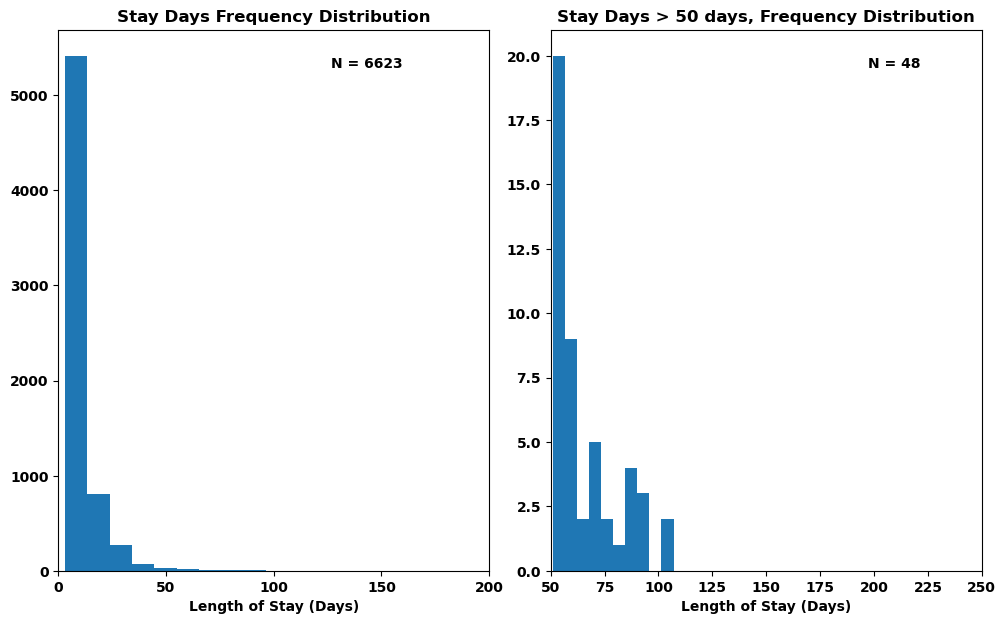

In [76]:
#print(intsl_notes_less_3.columns)
#intsl_notes[['stay_days','hadm_id']].groupby('stay_days').agg({'hadm_id':['count']})[0:10]

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
abins = range(25,300,25)
kwargs = dict(alpha=0.65, bins=abins)


x_row = 0
x_col = 0
#print(intsl_notes_less_3.columns)
temp_x = intsl_notes_less_3['stay_days']
temp_xb = intsl_notes_less_3.loc[intsl_notes_less_3['stay_days'] > 50, 'stay_days'] 
  
atext = 'N = ' + str(len(temp_x))
axis[0].hist(temp_x, bins=10)
axis[0].set_xlim(0,200)
xtitle = 'Stay Days Frequency Distribution'
axis[0].text(0.8, 0.95, atext, horizontalalignment='right', verticalalignment='top', transform=axis[x_col].transAxes)
axis[0].set_xticks(range(0,250,50))
axis[0].set_title(xtitle)
axis[0].set_xlabel('Length of Stay (Days)')

atextb = 'N = ' + str(len(temp_xb))
axis[1].hist(temp_xb, bins=10)
axis[1].set_xlim(50,250)
xtitleb = 'Stay Days > 50 days, Frequency Distribution'
axis[1].text(2.0, .95, atextb, horizontalalignment='right', verticalalignment='top', transform=axis[x_col].transAxes)
#axis[0].set_xticks(range(0,250,50))
axis[1].set_title(xtitleb)
axis[1].set_xlabel('Length of Stay (Days)')

        
        
#plt.hist(intsl_notes_less_3['stay_days'], color='blue', edgecolor='black')
#large_stays = plt.hist(intsl_notes_less_3.loc[intsl_notes['stay_days'] > 100,'stay_days'], color='yellow', edgecolor='black')
#print(large_stays)

In [77]:
intsl_notes_less_3 = intsl_notes_less_3.sort_values(by=['subject_id','hadm_id'])
#intsl_notes = pd.merge(spec_intel_adms, intsl_notes_less_3,
#                        on = ['subject_id','hadm_id'],
#                        how = 'inner')
#print('intsl_notes columns: ',intsl_notes.columns)
print('intsl_notes less 3 shape: ',intsl_notes_less_3.shape)
print('unique-admissions: ',intsl_notes_less_3['hadm_id'].nunique())
intsl_notes_less_3.groupby('primary_icd10_code')['hadm_id'].nunique()

intsl_notes less 3 shape:  (6623, 19)
unique-admissions:  6623


primary_icd10_code
A41.51     173
A41.9     1092
I21.09     333
I21.19     273
I21.4     1014
I25.10    1226
I34.0       77
I35.2      159
I50.23      98
I50.9      347
J18.9      383
J69.0      404
J96.00     750
N17.9      294
Name: hadm_id, dtype: int64

In [78]:
intsl_notes.columns

Index(['index', 'subject_id', 'hadm_id', 'primary_icd9_code',
       'primary_icd10_code', 'icd_category', 'stay_days', 'admission_type',
       'admittime', 'dischtime', 'deathtime', 'insurance', 'language',
       'religion', 'marital_status', 'ethnicity', 'diagnosis', 'ethnic_group',
       'row_id', 'chartdate', 'charttime', 'storetime', 'category',
       'description', 'cgid', 'iserror', 'text', 'admittime_c'],
      dtype='object')

In [79]:
# The less_N_days_report function eliminates those notes created greater than 3 days from admission.
# This query does not do that, therefore the total counts are grreater than the combined note.
# This query goves soem sense of the total bytes in notes > 3 days
# Use the finction mentipned aboive to make sure that the notes are combined correctly.

import pandasql as ps

#qintsl = intsl_notes[['note_length', 'text']]
# print(qintsl.dtypes)
input_df = intsl_notes[intsl_notes.stay_days >= 3]
q21 = """SELECT l3.subject_id, l3.hadm_id, l3.note_length, sum(length(inote.text)) as calc_length 
        FROM intsl_notes_less_3 l3 
        inner join input_df inote 
        on (l3.subject_id = inote.subject_id and l3.hadm_id = inote.hadm_id) 
        group by l3.subject_id, l3.hadm_id, l3.note_length 
        LIMIT 20"""

q22 = """SELECT l3.subject_id, l3.hadm_id, length(l3.text) as total_text_length, l3.note_length, length(inote.text) as text_length 
        FROM intsl_notes_less_3 l3 
        inner join pn_notes inote 
        on (l3.subject_id = inote.subject_id and l3.hadm_id = inote.hadm_id) 
        where l3.hadm_id = 145834
        LIMIT 40"""


p21 = ps.sqldf(q21, locals())
print(p21)


    subject_id  hadm_id  note_length  calc_length
0            3   145834        15017        21581
1           13   143045         7912         8709
2           21   109451         9896        14663
3           25   129635        11662        11652
4           33   176176         4894         4892
5           37   188670         2673         2672
6           44   181750         4391         7308
7           79   181542         4121         4116
8           85   116630         8714         8707
9           97   127870         3143         6258
10          99   187373         3511         3508
11         101   175533        11542        27442
12         105   161160         9276        12092
13         108   123552         1049         2334
14         111   192123        20569        46860
15         123   195632         3927         3924
16         130   198214         4350         7026
17         133   191817         7871        14330
18         149   154869         7132         7128


<div class="alert alert-block alert-success"><font color="black"><h1><left>Note Sizes and Counts By Diagnosis Code For Combined Notes</left></h1></font></div>

In [80]:
lnotes = intsl_notes_less_3.groupby(['primary_icd10_code']).agg(min=('note_length', 'min'), median=('note_length','median'),
                                                            max=('note_length','max') , count=('hadm_id','nunique')).round(1)
print("Note Size by Diagnosis Code")
print(lnotes)

admstayhrs = intsl_notes_less_3.groupby(['primary_icd10_code']).agg(min=('stay_days', 'min'), median=('stay_days','median'),
                                                            max=('stay_days','max') , count=('hadm_id','nunique')).round(1)
print("Stay (Days) by Diagnosis")
print(admstayhrs)

Note Size by Diagnosis Code
                     min   median     max  count
primary_icd10_code                              
A41.51               894  12649.0  360836    173
A41.9                524  12123.0  394675   1092
I21.09               908   7155.0  249570    333
I21.19               459   6275.0  268476    273
I21.4                212   6807.0  287419   1014
I25.10               102   3818.5  189476   1226
I34.0                591   5934.0  158347     77
I35.2                476   4476.0  195655    159
I50.23               940  45504.0  241758     98
I50.9                477   6319.0  171771    347
J18.9                238   9122.0  247497    383
J69.0                559   9513.0  302843    404
J96.00              1044  12727.5  380505    750
N17.9                690   7586.0  224034    294
Stay (Days) by Diagnosis
                    min  median  max  count
primary_icd10_code                         
A41.51                3     7.0   56    173
A41.9                 3     7.0

<div class="alert alert-block alert-success"><font color="black"><h1><left>Is There a Relationship between Length of Stay and Note Size</left></h1></font></div>

{'Heart': 'Lungs', 'Lungs': 'Kidney', 'Kidney': 'Heart'}
Heart Lungs
Lungs Kidney
Kidney Heart


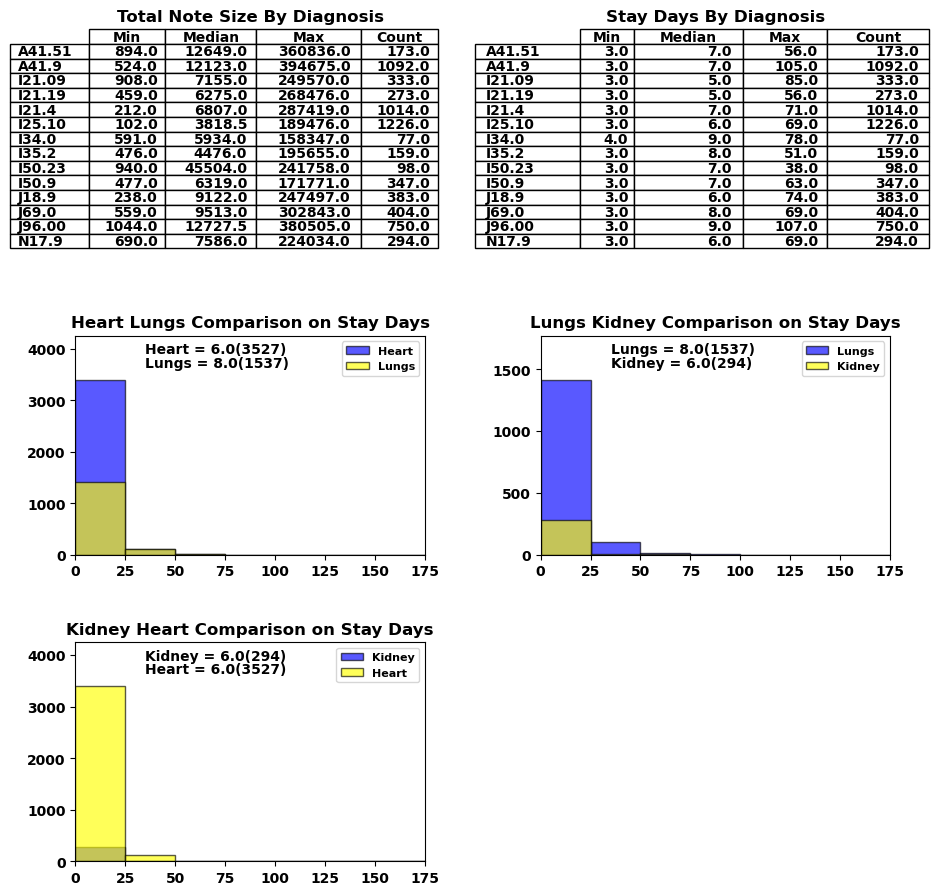

In [81]:
import matplotlib.pyplot as plt
import pandas as pd


figure, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
figure.tight_layout(pad=5.0) # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.4)

bbox = [0, 0, 1, 1]
axis[0,0].axis('tight')
axis[0,0].axis('off')
axis[0,0].set_title('Total Note Size By Diagnosis')
axis[0,0].margins(0,0.50)
clabels = ['Min', 'Median', 'Max', 'Count']
mpl_table = axis[0,0].table(cellText=lnotes.values, rowLabels=lnotes.index, bbox=bbox, colLabels=clabels)
mpl_table.auto_set_column_width(col=list(range(len(lnotes.columns))))
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(10)
mpl_table.scale(4,5)

sbbox = [0, 0, 1, 1]
axis[0,1].axis('tight')
axis[0,1].axis('off')
axis[0,1].set_title('Stay Days By Diagnosis')
slabels = ['Min', 'Median', 'Max', 'Count']
axis[0,1].margins(0,0.50)
spl_table = axis[0,1].table(cellText=admstayhrs.values, rowLabels=admstayhrs.index, bbox=sbbox, colLabels=slabels)
spl_table.auto_set_font_size(False)
spl_table.auto_set_column_width(col=list(range(len(admstayhrs.columns))))
spl_table.set_fontsize(10)
spl_table.scale(4,5)
                          
                          
icd_codes_groups = {'Heart': 'Lungs', 'Lungs': 'Kidney', 'Kidney': 'Heart'}
print(icd_codes_groups)

abins = range(0,200,25)
kwargs = dict(alpha=0.65, bins=abins)

x_row = 1
x_col = 0

for code_1, code_2 in icd_codes_groups.items():
    
    print(code_1, code_2)

    xm = intsl_notes_less_3.loc[(intsl_notes_less_3['icd_category'].str.contains(code_1)),'stay_days']
    xs = intsl_notes_less_3.loc[(intsl_notes_less_3['icd_category'].str.contains(code_2)),'stay_days']
    
    atext = code_1 + ' = ' + str(xm.median()) + '(' + str(xm.count()) + ')'
    btext = code_2 + ' = ' + str(xs.median()) + '(' + str(xs.count()) + ')'
    
    
    axis[x_row,x_col].hist(xm, **kwargs, color='blue', edgecolor='black',label=str(code_1))
    axis[x_row,x_col].hist(xs, **kwargs, color='yellow', edgecolor='black',label=str(code_2))
    xtitle = code_1 + ' ' + code_2 + ' Comparison on Stay Days'
    axis[x_row,x_col].text(0.20, 0.97, atext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.20, 0.91, btext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].legend(fontsize="8")
    axis[x_row,x_col].set_title(xtitle)
    #axis[x_row,x_col].set_yticks(range(0,550,100))
    axis[x_row,x_col].margins(0,0.25) 
    if x_col == 0:
        x_col += 1
    else:
        x_row += 1
        x_col = 0
axis[2,1].set_axis_off()        
plt.show()

In [82]:
dc = intsl_notes_less_3["primary_icd10_code"]
ms = intsl_notes_less_3["marital_status"]
ins = intsl_notes_less_3["insurance"]
rel = intsl_notes_less_3["religion"]
print(pd.crosstab(dc,ms))
print(pd.crosstab(dc,ins))
pd.crosstab(dc,rel)

marital_status      DIVORCED  LIFE PARTNER  MARRIED  SEPARATED  SINGLE  \
primary_icd10_code                                                       
A41.51                    13             0       74          2      41   
A41.9                     67             0      492         12     271   
I21.09                    12             0      177          0      59   
I21.19                    12             0      157          2      41   
I21.4                     52             0      550          6     125   
I25.10                    63             0      812          5     137   
I34.0                      4             0       50          1      10   
I35.2                      7             0       82          0      18   
I50.23                     7             1       49          0      26   
I50.9                     19             0      176          4      57   
J18.9                     18             0      159          6     107   
J69.0                     19          

religion,7TH DAY ADVENTIST,BAPTIST,BUDDHIST,CATHOLIC,CHRISTIAN SCIENTIST,EPISCOPALIAN,GREEK ORTHODOX,HEBREW,HINDU,JEHOVAH'S WITNESS,JEWISH,LUTHERAN,METHODIST,MUSLIM,NOT SPECIFIED,OTHER,PROTESTANT QUAKER,ROMANIAN EAST. ORTH,UNITARIAN-UNIVERSALIST,UNOBTAINABLE
primary_icd10_code,,,,,,,,,,,,,,,,,,,,
A41.51,0,1,2,61,0,1,2,0,3,0,30,0,0,0,26,13,20,0,1,13
A41.9,1,0,5,386,2,20,6,0,3,7,170,0,0,4,177,43,150,1,1,111
I21.09,0,0,0,110,4,4,4,0,1,0,35,0,0,2,44,25,25,2,0,57
I21.19,1,0,0,105,1,4,2,0,0,0,22,0,0,2,34,13,34,0,0,43
I21.4,2,0,2,395,3,15,11,0,2,5,126,0,0,1,109,59,134,1,2,128
I25.10,0,1,1,482,3,14,9,2,2,0,110,0,0,5,148,116,147,2,0,147
I34.0,0,0,0,33,0,1,0,0,0,0,5,0,1,0,10,7,10,0,0,10
I35.2,1,0,0,64,1,3,1,1,0,0,17,0,0,1,21,18,15,0,1,11
I50.23,0,0,1,41,0,0,1,0,1,1,20,0,0,0,14,1,17,0,0,1


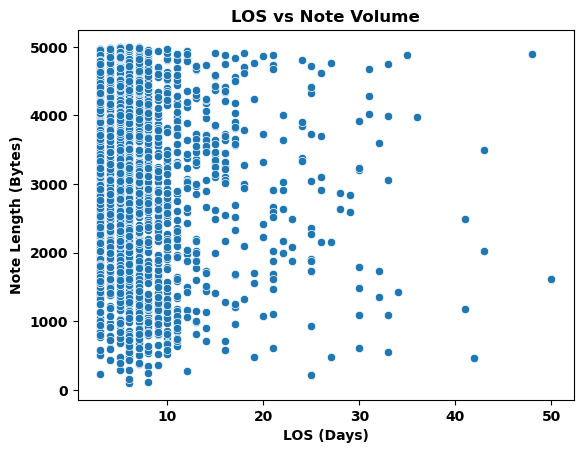

In [83]:
import seaborn as sns

#print(intsl_notes.columns)
# print(type(lnotes))
# median_note_size = lnotes['median']
# median_los = admstayhrs['median']
ax = sns.scatterplot(x='stay_days', y='note_length', data=intsl_notes_less_3[(intsl_notes_less_3.stay_days <= 50) & (intsl_notes_less_3.note_length <= 5000)])
ax.set_title("LOS vs Note Volume")
ax.set_xlabel("LOS (Days)");
ax.set_ylabel("Note Length (Bytes)");
# print(median_note_size)
#lnotes.columns

In [84]:
# This shows that the correlation between stay hours and total note length was very low 
import numpy as np
import scipy.stats
r, p = scipy.stats.pearsonr(x=intsl_notes_less_3['stay_days'], y=intsl_notes_less_3['note_length'])
print('Pearson : ', r, ' P-Value : ', p)

Pearson :  0.06533939384029999  P-Value :  1.0256353984322181e-07


In [85]:
print(len(intsl_notes['hadm_id'].unique()))
intsl_notes.columns
print('I35.2 admissions: ', intsl_notes_less_3[intsl_notes_less_3['primary_icd10_code']=='I35.2'].shape[0])

11550
I35.2 admissions:  159


In [86]:
# Not sure what thos does
base_adms = intsl_notes_less_3
smaller_adms_list = list(intsl_notes.hadm_id)
print('list ',len(smaller_adms_list))
smaller_adms = base_adms[base_adms['hadm_id'].isin(smaller_adms_list)]
print('base_adms: ',base_adms.shape)
base_adms = smaller_adms.merge(intsl_notes_less_3[['subject_id','hadm_id']], on=['subject_id', 'hadm_id'])
print('final base: ', base_adms.shape[0])
#base_adms.columns


list  201389
base_adms:  (6623, 19)
final base:  6623


<div class="alert alert-block alert-success"><font color="black"><h1><left>Write File with Admission Details and Attached Combined Notes</left></h1></font></div>

In [264]:
# find patients who died
good_adms = intsl_notes_less_3[intsl_notes_less_3.deathtime.isnull()]
print(len(good_adms), len(intsl_notes_less_3), len(intsl_notes_less_3.hadm_id.unique()))

5952 6623 6623


In [271]:
#good_adms.columns
#good_adms.groupby('ethnic_group')['hadm_id'].nunique()
#full_adms.columns
admissions['ethnic_group'] = admissions.apply(lambda row: set_ethnic_group(row['ethnicity']), axis = 1)
admissions.groupby('ethnic_group')['hadm_id'].nunique()

ethnic_group
A     2007
B     5794
H     2197
I       72
M       43
O     1642
U     5896
W    41325
Name: hadm_id, dtype: int64

In [155]:
# find discharge only for selected admissions
selected_patients = good_adms[["subject_id", "hadm_id"]].drop_duplicates()
discharge_adms = pd.merge(selected_patients, discharge_concat_df, on=["subject_id", "hadm_id"], how = 'inner')
#discharge_adms[0:3] 
print(len(discharge_adms), len(discharge_adms.hadm_id.unique()), 
      len(good_adms), len(selected_patients.hadm_id.unique()))

5926 5926 5952 5952


In [156]:
path = 'E:/Education/CCSU-Thesis-2024/Data/'
good_adms.to_parquet(path + 'pd_notes.snappy4.parquet',compression='snappy',index=None)  
discharge_adms.to_parquet(path + 'discharge_notes.snappy4.parquet',compression='snappy',index=None)  
base_adms.to_parquet(path + 'base_adms.snappy3.parquet',compression='snappy',index=None)  

NameError: name 'base_adms' is not defined

In [ ]:
intsl_notes_less_3.columns

In [ ]:
print('intsl_notes_less_3', intsl_notes.shape)
print('spec_intel_amds',spec_intel_adms.shape)
base_adms.shape

In [ ]:
import boto3, os
s3 = boto3.resource('s3')
path = 'E:/Education/CCSU-Thesis-2024/Data/'
fname = 'pd_notes.snappy3.parquet'
f2name = 'discharge_notes.snappy3.parquet'
f3name = 'base_adms.snappy3.parquet'
S3_path = 'Data/' + fname
S3_path2 = 'Data/' + f2name
S3_path3 = 'Data/' + f3name
out_file = path + fname
out_file2 = path + f2name
out_file3 = path + f3name

In [ ]:
s3.meta.client.upload_file(out_file, 'depratti-masters-thesis', S3_path)

In [ ]:
s3.meta.client.upload_file(out_file2, 'depratti-masters-thesis', S3_path2)

In [ ]:
#s3.meta.client.upload_file(out_file3, 'depratti-masters-thesis', S3_path3)

In [ ]:
good_adms.groupby('primary_icd10_code')['hadm_id'].count()